# Approximating h

We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to approximate the function $h = x_3 \cdot x_1^{x_2}$

Use this first cell to convert the notebook to a python script.

In [1]:
!jupyter nbconvert script.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

[NbConvertApp] Converting notebook script.ipynb to script
[NbConvertApp] Writing 13105 bytes to script.py


In [2]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import optuna
import tensorboardX as tbx
import matplotlib.pyplot as plt


In [3]:

# Defining the function to approximate
def f(x1, x2, x3):
    return x1 + x2 + x3

# Generating the data samples
nsamples = 10**5

x1min = x2min = x3min = -10
x1max = x2max = x3max = 10

np.random.seed(0)
x1 = np.random.uniform(x1min, x1max, size=nsamples)
x2 = np.random.uniform(x2min, x2max, size=nsamples)
x3 = np.random.uniform(x3min, x3max, size=nsamples)
y = f(x1, x2, x3)

# Converting the data to tensors
x1 = torch.from_numpy(x1).float()
x2 = torch.from_numpy(x2).float()
x3 = torch.from_numpy(x3).float()
y = torch.from_numpy(y).float()

# Stacking the inputs into a single tensor
x = torch.stack([x1, x2, x3], dim=1)

# Splitting the data into train and test sets
train_size = int(0.8 * len(x))
test_size = len(x) - train_size
x_train, x_test = torch.split(x, [train_size, test_size])
y_train, y_test = torch.split(y, [train_size, test_size])


In [4]:

# Defining a custom neural network class
class Net(nn.Module):
    """A custom neural network class that approximates the function h.

    Args:
        n_layers (int): The number of hidden layers in the network.
        n_units (int): The number of hidden units in each layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
    """
    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        super(Net, self).__init__()
        # Creating a list of linear layers with n_units each
        self.layers = nn.ModuleList([nn.Linear(3, n_units)])
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(n_units, n_units))
        # Adding the final output layer with one unit
        self.layers.append(nn.Linear(n_units, 1))
        # Storing the activation functions
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

    def forward(self, x):
        """Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Passing the input through the hidden layers with the hidden activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Passing the output through the final layer with the output activation function
        x = self.output_activation(self.layers[-1](x))
        return x


## Setting the search space

In [5]:

# Defining a function to create a trial network and optimizer
def create_model(trial):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler), where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler.
    """

    # Sampling the hyperparameters from the search space
    n_layers = trial.suggest_int("n_layers", 1, 2)
    n_units = trial.suggest_int("n_units", 2, 32)
    hidden_activation_name = trial.suggest_categorical("hidden_activation", ["ReLU"])
    output_activation_name = trial.suggest_categorical("output_activation", ["ReLU", "Tanh", "Sigmoid"])
    loss_name = trial.suggest_categorical("loss", ["MSE", "MAE"])
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_int("batch_size", 32, 512)
    n_epochs = trial.suggest_int("n_epochs", 10, 20)
    scheduler_name = "None"

    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Tanh":
        output_activation = nn.Tanh()
    else:
        output_activation = nn.Sigmoid()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    else:
        loss_fn = nn.SmoothL1Loss()

    # Creating the network with the sampled hyperparameters
    net = Net(n_layers, n_units, hidden_activation, output_activation)

    # Creating the optimizer from its name
    if optimizer_name == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=lr)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=lr)
    else:
        optimizer = optim.RMSprop(net.parameters(), lr=lr)

    # Creating the learning rate scheduler from its name
    if scheduler_name == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    else:
        scheduler = None

    # Returning the network, the loss function, the optimizer, the batch size, the number of epochs and the scheduler
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler


## The train and eval loop

In [6]:

# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler):
    """Trains and evaluates a network on the train and test sets.

    Args:
        net (Net): The network to train and evaluate.
        loss_fn (torch.nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        batch_size (int): The batch size to use.
        n_epochs (int): The number of epochs to train for.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.

    Returns:
        tuple: A tuple of (train_losses, test_losses,
            train_accuracies, test_accuracies), where train_losses and test_losses are lists of average losses per epoch for the train and test sets,
            train_accuracies and test_accuracies are lists of average accuracies per epoch for the train and test sets.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size)

    # Initializing lists to store the losses and accuracies for each epoch
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Looping over the epochs
    for epoch in range(n_epochs):
        # Setting the network to training mode
        net.train()
        # Initializing variables to store the total loss and correct predictions for the train set
        train_loss = 0.0
        train_correct = 0
        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:
            # Zeroing the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = net(x_batch)
            # Reshaping the target tensor to match the input tensor
            y_batch = y_batch.view(-1, 1)
            # Computing the loss
            loss = loss_fn(y_pred, y_batch)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # Updating the total loss and correct predictions
            train_loss += loss.item() * x_batch.size(0)
            train_correct += torch.sum((y_pred - y_batch).abs() < 1e-3)

        # Updating the learning rate scheduler if applicable
        if scheduler is not None:
            scheduler.step()

        # Setting the network to evaluation mode
        net.eval()
        # Initializing variables to store the total loss and correct predictions for the test set
        test_loss = 0.0
        test_correct = 0
        # Looping over the batches in the test set
        for x_batch, y_batch in test_loader:
            # Forward pass
            y_pred = net(x_batch)
            # Reshaping the target tensor to match the input tensor
            y_batch = y_batch.view(-1, 1)
            # Computing the loss
            loss = loss_fn(y_pred, y_batch)
            # Updating the total loss and correct predictions
            test_loss += loss.item() * x_batch.size(0)
            test_correct += torch.sum((y_pred - y_batch).abs() < 1e-3)

        # Computing the average losses and accuracies for the train and test sets
        train_loss /= len(x_train)
        test_loss /= len(x_test)
        train_accuracy = train_correct / len(x_train)
        test_accuracy = test_correct / len(x_test)

        # Appending the losses and accuracies to the lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Printing the epoch summary
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Returning the lists of losses and accuracies
    return train_losses, test_losses, train_accuracies, test_accuracies


In [7]:

# Defining a function to compute the objective value for a trial
def objective(trial):
    """Computes the objective value (final test loss) for a trial.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The objective value (final test loss) for the trial.
    """
    # Creating a trial network and optimizer with the create_model function
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler = create_model(trial)

    # Training and evaluating the network with the train_and_eval function
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler)

    # Returning the final test loss as the objective value
    return test_losses[-1]


## Finding the best hyperparameters with Optuna

In [8]:

# Creating a study object with Optuna
study = optuna.create_study(direction="minimize")

# Running the optimization for 100 trials
study.optimize(objective, n_trials=100)


[I 2023-05-03 05:09:10,469] A new study created in memory with name: no-name-de0b58eb-983a-475e-ba73-cbffc338952a
/tmp/ipykernel_8668/1593882797.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)


Epoch 1: Train Loss: 94.3009, Train Accuracy: 0.0001, Test Loss: 93.1808, Test Accuracy: 0.0001
Epoch 2: Train Loss: 92.8974, Train Accuracy: 0.0001, Test Loss: 92.7885, Test Accuracy: 0.0002
Epoch 3: Train Loss: 92.6839, Train Accuracy: 0.0001, Test Loss: 92.6751, Test Accuracy: 0.0000
Epoch 4: Train Loss: 92.6051, Train Accuracy: 0.0001, Test Loss: 92.6207, Test Accuracy: 0.0000
Epoch 5: Train Loss: 92.5625, Train Accuracy: 0.0001, Test Loss: 92.5877, Test Accuracy: 0.0001
Epoch 6: Train Loss: 92.5352, Train Accuracy: 0.0001, Test Loss: 92.5653, Test Accuracy: 0.0000
Epoch 7: Train Loss: 92.5159, Train Accuracy: 0.0001, Test Loss: 92.5489, Test Accuracy: 0.0001
Epoch 8: Train Loss: 92.5015, Train Accuracy: 0.0001, Test Loss: 92.5363, Test Accuracy: 0.0000
Epoch 9: Train Loss: 92.4902, Train Accuracy: 0.0001, Test Loss: 92.5263, Test Accuracy: 0.0000
Epoch 10: Train Loss: 92.4811, Train Accuracy: 0.0001, Test Loss: 92.5182, Test Accuracy: 0.0000
Epoch 11: Train Loss: 92.4736, Train Ac

[I 2023-05-03 05:09:26,702] Trial 0 finished with value: 92.48943647975922 and parameters: {'n_layers': 1, 'n_units': 15, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.0008796295886730333, 'batch_size': 229, 'n_epochs': 16}. Best is trial 0 with value: 92.48943647975922.


Epoch 16: Train Loss: 92.4498, Train Accuracy: 0.0002, Test Loss: 92.4894, Test Accuracy: 0.0002
Epoch 1: Train Loss: 8.0296, Train Accuracy: 0.0001, Test Loss: 7.9785, Test Accuracy: 0.0002
Epoch 2: Train Loss: 7.9425, Train Accuracy: 0.0000, Test Loss: 7.8872, Test Accuracy: 0.0000
Epoch 3: Train Loss: 7.8505, Train Accuracy: 0.0001, Test Loss: 7.7965, Test Accuracy: 0.0002
Epoch 4: Train Loss: 7.7642, Train Accuracy: 0.0000, Test Loss: 7.7157, Test Accuracy: 0.0001
Epoch 5: Train Loss: 7.6893, Train Accuracy: 0.0000, Test Loss: 7.6463, Test Accuracy: 0.0000
Epoch 6: Train Loss: 7.6247, Train Accuracy: 0.0001, Test Loss: 7.5862, Test Accuracy: 0.0000
Epoch 7: Train Loss: 7.5687, Train Accuracy: 0.0001, Test Loss: 7.5340, Test Accuracy: 0.0000
Epoch 8: Train Loss: 7.5206, Train Accuracy: 0.0001, Test Loss: 7.4898, Test Accuracy: 0.0000
Epoch 9: Train Loss: 7.4804, Train Accuracy: 0.0001, Test Loss: 7.4535, Test Accuracy: 0.0001
Epoch 10: Train Loss: 7.4477, Train Accuracy: 0.0001, Tes

[I 2023-05-03 05:09:45,550] Trial 1 finished with value: 7.298453163981438 and parameters: {'n_layers': 2, 'n_units': 15, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00037614524845698213, 'batch_size': 309, 'n_epochs': 19}. Best is trial 1 with value: 7.298453163981438.


Epoch 19: Train Loss: 7.3116, Train Accuracy: 0.0001, Test Loss: 7.2985, Test Accuracy: 0.0001
Epoch 1: Train Loss: 4.6568, Train Accuracy: 0.0016, Test Loss: 4.0736, Test Accuracy: 0.0076
Epoch 2: Train Loss: 4.1065, Train Accuracy: 0.0047, Test Loss: 4.1146, Test Accuracy: 0.0019
Epoch 3: Train Loss: 4.1065, Train Accuracy: 0.0048, Test Loss: 4.0795, Test Accuracy: 0.0020
Epoch 4: Train Loss: 4.0977, Train Accuracy: 0.0063, Test Loss: 4.0984, Test Accuracy: 0.0010
Epoch 5: Train Loss: 4.1030, Train Accuracy: 0.0051, Test Loss: 4.0657, Test Accuracy: 0.0030
Epoch 6: Train Loss: 4.0977, Train Accuracy: 0.0061, Test Loss: 4.1134, Test Accuracy: 0.0008
Epoch 7: Train Loss: 4.0968, Train Accuracy: 0.0062, Test Loss: 4.0479, Test Accuracy: 0.0192
Epoch 8: Train Loss: 4.0903, Train Accuracy: 0.0074, Test Loss: 4.0475, Test Accuracy: 0.0171
Epoch 9: Train Loss: 4.0864, Train Accuracy: 0.0079, Test Loss: 4.0622, Test Accuracy: 0.0038
Epoch 10: Train Loss: 4.0910, Train Accuracy: 0.0077, Test 

[I 2023-05-03 05:09:56,784] Trial 2 finished with value: 4.081453324151039 and parameters: {'n_layers': 2, 'n_units': 15, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.005022594360266957, 'batch_size': 333, 'n_epochs': 11}. Best is trial 2 with value: 4.081453324151039.


Epoch 11: Train Loss: 4.0999, Train Accuracy: 0.0057, Test Loss: 4.0815, Test Accuracy: 0.0010
Epoch 1: Train Loss: 51.0251, Train Accuracy: 0.0020, Test Loss: 49.6941, Test Accuracy: 0.0032
Epoch 2: Train Loss: 50.2445, Train Accuracy: 0.0029, Test Loss: 49.6895, Test Accuracy: 0.0044
Epoch 3: Train Loss: 50.2416, Train Accuracy: 0.0041, Test Loss: 49.6876, Test Accuracy: 0.0050
Epoch 4: Train Loss: 50.2402, Train Accuracy: 0.0044, Test Loss: 49.6865, Test Accuracy: 0.0056
Epoch 5: Train Loss: 50.2393, Train Accuracy: 0.0055, Test Loss: 49.6859, Test Accuracy: 0.0053
Epoch 6: Train Loss: 50.2388, Train Accuracy: 0.0060, Test Loss: 49.6855, Test Accuracy: 0.0070
Epoch 7: Train Loss: 50.2384, Train Accuracy: 0.0069, Test Loss: 49.6853, Test Accuracy: 0.0064
Epoch 8: Train Loss: 50.2382, Train Accuracy: 0.0066, Test Loss: 49.6849, Test Accuracy: 0.0063
Epoch 9: Train Loss: 50.2379, Train Accuracy: 0.0072, Test Loss: 49.6847, Test Accuracy: 0.0074
Epoch 10: Train Loss: 50.2377, Train Accu

[I 2023-05-03 05:10:09,274] Trial 3 finished with value: 49.68414399394989 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.005062425231306382, 'batch_size': 281, 'n_epochs': 13}. Best is trial 2 with value: 4.081453324151039.


Epoch 13: Train Loss: 50.2373, Train Accuracy: 0.0082, Test Loss: 49.6841, Test Accuracy: 0.0091
Epoch 1: Train Loss: 8.1342, Train Accuracy: 0.0001, Test Loss: 8.1254, Test Accuracy: 0.0001
Epoch 2: Train Loss: 8.1334, Train Accuracy: 0.0001, Test Loss: 8.1246, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1326, Train Accuracy: 0.0001, Test Loss: 8.1238, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1318, Train Accuracy: 0.0001, Test Loss: 8.1230, Test Accuracy: 0.0001
Epoch 5: Train Loss: 8.1310, Train Accuracy: 0.0001, Test Loss: 8.1223, Test Accuracy: 0.0001
Epoch 6: Train Loss: 8.1302, Train Accuracy: 0.0001, Test Loss: 8.1215, Test Accuracy: 0.0001
Epoch 7: Train Loss: 8.1295, Train Accuracy: 0.0001, Test Loss: 8.1207, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1287, Train Accuracy: 0.0001, Test Loss: 8.1200, Test Accuracy: 0.0001
Epoch 9: Train Loss: 8.1279, Train Accuracy: 0.0001, Test Loss: 8.1192, Test Accuracy: 0.0001
Epoch 10: Train Loss: 8.1271, Train Accuracy: 0.0001, Tes

[I 2023-05-03 05:10:23,445] Trial 4 finished with value: 8.114815501499177 and parameters: {'n_layers': 2, 'n_units': 3, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00011745706721447401, 'batch_size': 378, 'n_epochs': 15}. Best is trial 2 with value: 4.081453324151039.


Epoch 15: Train Loss: 8.1234, Train Accuracy: 0.0000, Test Loss: 8.1148, Test Accuracy: 0.0000
Epoch 1: Train Loss: 8.1273, Train Accuracy: 0.0001, Test Loss: 8.1134, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1156, Train Accuracy: 0.0000, Test Loss: 8.1008, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1015, Train Accuracy: 0.0001, Test Loss: 8.0852, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.0837, Train Accuracy: 0.0001, Test Loss: 8.0656, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.0623, Train Accuracy: 0.0000, Test Loss: 8.0430, Test Accuracy: 0.0001
Epoch 6: Train Loss: 8.0389, Train Accuracy: 0.0001, Test Loss: 8.0194, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.0155, Train Accuracy: 0.0000, Test Loss: 7.9964, Test Accuracy: 0.0000
Epoch 8: Train Loss: 7.9931, Train Accuracy: 0.0000, Test Loss: 7.9742, Test Accuracy: 0.0000
Epoch 9: Train Loss: 7.9715, Train Accuracy: 0.0000, Test Loss: 7.9526, Test Accuracy: 0.0000
Epoch 10: Train Loss: 7.9503, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:10:46,166] Trial 5 finished with value: 7.754007665777206 and parameters: {'n_layers': 2, 'n_units': 4, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0014442890923074179, 'batch_size': 211, 'n_epochs': 20}. Best is trial 2 with value: 4.081453324151039.


Epoch 20: Train Loss: 7.7685, Train Accuracy: 0.0001, Test Loss: 7.7540, Test Accuracy: 0.0001
Epoch 1: Train Loss: 50.8654, Train Accuracy: 0.0019, Test Loss: 49.6992, Test Accuracy: 0.0019
Epoch 2: Train Loss: 50.2485, Train Accuracy: 0.0031, Test Loss: 49.6933, Test Accuracy: 0.0031
Epoch 3: Train Loss: 50.2446, Train Accuracy: 0.0033, Test Loss: 49.6905, Test Accuracy: 0.0038
Epoch 4: Train Loss: 50.2425, Train Accuracy: 0.0035, Test Loss: 49.6887, Test Accuracy: 0.0041
Epoch 5: Train Loss: 50.2411, Train Accuracy: 0.0042, Test Loss: 49.6876, Test Accuracy: 0.0043
Epoch 6: Train Loss: 50.2401, Train Accuracy: 0.0047, Test Loss: 49.6867, Test Accuracy: 0.0048
Epoch 7: Train Loss: 50.2394, Train Accuracy: 0.0057, Test Loss: 49.6861, Test Accuracy: 0.0052
Epoch 8: Train Loss: 50.2389, Train Accuracy: 0.0062, Test Loss: 49.6856, Test Accuracy: 0.0063
Epoch 9: Train Loss: 50.2385, Train Accuracy: 0.0065, Test Loss: 49.6853, Test Accuracy: 0.0060
Epoch 10: Train Loss: 50.2382, Train Accu

[I 2023-05-03 05:11:03,698] Trial 6 finished with value: 49.68378762245178 and parameters: {'n_layers': 1, 'n_units': 28, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.0037019215707509083, 'batch_size': 314, 'n_epochs': 19}. Best is trial 2 with value: 4.081453324151039.


Epoch 19: Train Loss: 50.2369, Train Accuracy: 0.0090, Test Loss: 49.6838, Test Accuracy: 0.0087
Epoch 1: Train Loss: 99.5398, Train Accuracy: 0.0001, Test Loss: 97.6793, Test Accuracy: 0.0001
Epoch 2: Train Loss: 96.4467, Train Accuracy: 0.0001, Test Loss: 95.4786, Test Accuracy: 0.0000
Epoch 3: Train Loss: 94.8620, Train Accuracy: 0.0000, Test Loss: 94.3835, Test Accuracy: 0.0000
Epoch 4: Train Loss: 94.0272, Train Accuracy: 0.0000, Test Loss: 93.7761, Test Accuracy: 0.0003
Epoch 5: Train Loss: 93.5438, Train Accuracy: 0.0002, Test Loss: 93.4104, Test Accuracy: 0.0002
Epoch 6: Train Loss: 93.2449, Train Accuracy: 0.0001, Test Loss: 93.1765, Test Accuracy: 0.0000
Epoch 7: Train Loss: 93.0501, Train Accuracy: 0.0001, Test Loss: 93.0186, Test Accuracy: 0.0000
Epoch 8: Train Loss: 92.9167, Train Accuracy: 0.0002, Test Loss: 92.9072, Test Accuracy: 0.0002
Epoch 9: Train Loss: 92.8215, Train Accuracy: 0.0001, Test Loss: 92.8257, Test Accuracy: 0.0002
Epoch 10: Train Loss: 92.7508, Train Ac

[I 2023-05-03 05:11:21,993] Trial 7 finished with value: 92.52619913711548 and parameters: {'n_layers': 1, 'n_units': 10, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.00035196699074302413, 'batch_size': 459, 'n_epochs': 20}. Best is trial 2 with value: 4.081453324151039.


Epoch 20: Train Loss: 92.4900, Train Accuracy: 0.0001, Test Loss: 92.5262, Test Accuracy: 0.0000
Epoch 1: Train Loss: 7.7903, Train Accuracy: 0.0001, Test Loss: 7.6808, Test Accuracy: 0.0003
Epoch 2: Train Loss: 7.6749, Train Accuracy: 0.0001, Test Loss: 7.6578, Test Accuracy: 0.0001
Epoch 3: Train Loss: 7.6610, Train Accuracy: 0.0001, Test Loss: 7.6491, Test Accuracy: 0.0002
Epoch 4: Train Loss: 7.6545, Train Accuracy: 0.0002, Test Loss: 7.6442, Test Accuracy: 0.0000
Epoch 5: Train Loss: 7.6506, Train Accuracy: 0.0002, Test Loss: 7.6411, Test Accuracy: 0.0003
Epoch 6: Train Loss: 7.6479, Train Accuracy: 0.0002, Test Loss: 7.6389, Test Accuracy: 0.0002
Epoch 7: Train Loss: 7.6460, Train Accuracy: 0.0002, Test Loss: 7.6371, Test Accuracy: 0.0003
Epoch 8: Train Loss: 7.6446, Train Accuracy: 0.0003, Test Loss: 7.6360, Test Accuracy: 0.0003
Epoch 9: Train Loss: 7.6435, Train Accuracy: 0.0003, Test Loss: 7.6350, Test Accuracy: 0.0004
Epoch 10: Train Loss: 7.6426, Train Accuracy: 0.0005, Tes

[I 2023-05-03 05:11:46,583] Trial 8 finished with value: 7.6316068643569945 and parameters: {'n_layers': 2, 'n_units': 23, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.011065616626542991, 'batch_size': 104, 'n_epochs': 17}. Best is trial 2 with value: 4.081453324151039.


Epoch 17: Train Loss: 7.6399, Train Accuracy: 0.0007, Test Loss: 7.6316, Test Accuracy: 0.0007
Epoch 1: Train Loss: 8.0443, Train Accuracy: 0.0001, Test Loss: 8.0269, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.0255, Train Accuracy: 0.0001, Test Loss: 8.0083, Test Accuracy: 0.0002
Epoch 3: Train Loss: 8.0071, Train Accuracy: 0.0000, Test Loss: 7.9900, Test Accuracy: 0.0000
Epoch 4: Train Loss: 7.9892, Train Accuracy: 0.0000, Test Loss: 7.9723, Test Accuracy: 0.0000
Epoch 5: Train Loss: 7.9719, Train Accuracy: 0.0000, Test Loss: 7.9553, Test Accuracy: 0.0000
Epoch 6: Train Loss: 7.9553, Train Accuracy: 0.0000, Test Loss: 7.9391, Test Accuracy: 0.0000
Epoch 7: Train Loss: 7.9395, Train Accuracy: 0.0001, Test Loss: 7.9237, Test Accuracy: 0.0000
Epoch 8: Train Loss: 7.9246, Train Accuracy: 0.0001, Test Loss: 7.9091, Test Accuracy: 0.0001
Epoch 9: Train Loss: 7.9105, Train Accuracy: 0.0002, Test Loss: 7.8955, Test Accuracy: 0.0001
Epoch 10: Train Loss: 7.8972, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:12:01,798] Trial 9 finished with value: 7.81431379609108 and parameters: {'n_layers': 2, 'n_units': 17, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0005156220970116988, 'batch_size': 493, 'n_epochs': 17}. Best is trial 2 with value: 4.081453324151039.


Epoch 17: Train Loss: 7.8264, Train Accuracy: 0.0001, Test Loss: 7.8143, Test Accuracy: 0.0000
Epoch 1: Train Loss: 4.2900, Train Accuracy: 0.0012, Test Loss: 4.2891, Test Accuracy: 0.0005
Epoch 2: Train Loss: 4.2217, Train Accuracy: 0.0010, Test Loss: 4.2012, Test Accuracy: 0.0003
Epoch 3: Train Loss: 4.2312, Train Accuracy: 0.0016, Test Loss: 4.2298, Test Accuracy: 0.0003
Epoch 4: Train Loss: 4.2410, Train Accuracy: 0.0011, Test Loss: 4.1595, Test Accuracy: 0.0012
Epoch 5: Train Loss: 4.4353, Train Accuracy: 0.0008, Test Loss: 5.1348, Test Accuracy: 0.0002
Epoch 6: Train Loss: 4.3554, Train Accuracy: 0.0008, Test Loss: 4.2459, Test Accuracy: 0.0010
Epoch 7: Train Loss: 4.3072, Train Accuracy: 0.0013, Test Loss: 4.1685, Test Accuracy: 0.0010
Epoch 8: Train Loss: 4.3515, Train Accuracy: 0.0010, Test Loss: 4.7859, Test Accuracy: 0.0001
Epoch 9: Train Loss: 4.3811, Train Accuracy: 0.0011, Test Loss: 4.8868, Test Accuracy: 0.0003


[I 2023-05-03 05:12:36,496] Trial 10 finished with value: 4.099403851383925 and parameters: {'n_layers': 2, 'n_units': 23, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.09909635786253766, 'batch_size': 37, 'n_epochs': 10}. Best is trial 2 with value: 4.081453324151039.


Epoch 10: Train Loss: 4.4474, Train Accuracy: 0.0009, Test Loss: 4.0994, Test Accuracy: 0.0045
Epoch 1: Train Loss: 4.2741, Train Accuracy: 0.0013, Test Loss: 4.2781, Test Accuracy: 0.0004
Epoch 2: Train Loss: 4.1951, Train Accuracy: 0.0020, Test Loss: 4.2112, Test Accuracy: 0.0009
Epoch 3: Train Loss: 4.2367, Train Accuracy: 0.0014, Test Loss: 4.1688, Test Accuracy: 0.0014
Epoch 4: Train Loss: 4.2456, Train Accuracy: 0.0012, Test Loss: 4.3925, Test Accuracy: 0.0000
Epoch 5: Train Loss: 4.2400, Train Accuracy: 0.0012, Test Loss: 5.1556, Test Accuracy: 0.0002
Epoch 6: Train Loss: 4.3433, Train Accuracy: 0.0012, Test Loss: 4.1052, Test Accuracy: 0.0022
Epoch 7: Train Loss: 4.2652, Train Accuracy: 0.0013, Test Loss: 4.1870, Test Accuracy: 0.0010
Epoch 8: Train Loss: 4.2776, Train Accuracy: 0.0011, Test Loss: 4.4129, Test Accuracy: 0.0004
Epoch 9: Train Loss: 4.2948, Train Accuracy: 0.0012, Test Loss: 4.1181, Test Accuracy: 0.0016


[I 2023-05-03 05:13:06,273] Trial 11 finished with value: 4.171445997333526 and parameters: {'n_layers': 2, 'n_units': 23, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.09199249255194931, 'batch_size': 44, 'n_epochs': 10}. Best is trial 2 with value: 4.081453324151039.


Epoch 10: Train Loss: 4.2912, Train Accuracy: 0.0016, Test Loss: 4.1714, Test Accuracy: 0.0010
Epoch 1: Train Loss: 4.3016, Train Accuracy: 0.0010, Test Loss: 4.2262, Test Accuracy: 0.0004
Epoch 2: Train Loss: 4.2271, Train Accuracy: 0.0015, Test Loss: 4.1451, Test Accuracy: 0.0025
Epoch 3: Train Loss: 4.1842, Train Accuracy: 0.0018, Test Loss: 4.1140, Test Accuracy: 0.0023
Epoch 4: Train Loss: 4.1833, Train Accuracy: 0.0020, Test Loss: 4.1615, Test Accuracy: 0.0011
Epoch 5: Train Loss: 4.1614, Train Accuracy: 0.0021, Test Loss: 4.0747, Test Accuracy: 0.0032
Epoch 6: Train Loss: 4.1893, Train Accuracy: 0.0020, Test Loss: 4.0661, Test Accuracy: 0.0052
Epoch 7: Train Loss: 4.1737, Train Accuracy: 0.0020, Test Loss: 4.0767, Test Accuracy: 0.0047
Epoch 8: Train Loss: 4.1676, Train Accuracy: 0.0021, Test Loss: 4.0901, Test Accuracy: 0.0030
Epoch 9: Train Loss: 4.1568, Train Accuracy: 0.0025, Test Loss: 4.0874, Test Accuracy: 0.0024


[I 2023-05-03 05:13:20,299] Trial 12 finished with value: 4.214537603533268 and parameters: {'n_layers': 2, 'n_units': 22, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.07224345477261704, 'batch_size': 147, 'n_epochs': 10}. Best is trial 2 with value: 4.081453324151039.


Epoch 10: Train Loss: 4.1556, Train Accuracy: 0.0024, Test Loss: 4.2145, Test Accuracy: 0.0000
Epoch 1: Train Loss: 8.1224, Train Accuracy: 0.0001, Test Loss: 8.1084, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1114, Train Accuracy: 0.0001, Test Loss: 8.0960, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.0981, Train Accuracy: 0.0001, Test Loss: 8.0817, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.0833, Train Accuracy: 0.0001, Test Loss: 8.0662, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.0674, Train Accuracy: 0.0001, Test Loss: 8.0499, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.0508, Train Accuracy: 0.0001, Test Loss: 8.0330, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.0337, Train Accuracy: 0.0002, Test Loss: 8.0155, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.0161, Train Accuracy: 0.0001, Test Loss: 7.9977, Test Accuracy: 0.0000
Epoch 9: Train Loss: 7.9980, Train Accuracy: 0.0000, Test Loss: 7.9792, Test Accuracy: 0.0002
Epoch 10: Train Loss: 7.9794, Train Accuracy: 0.0002, Test 

[I 2023-05-03 05:13:32,714] Trial 13 finished with value: 7.919964679002762 and parameters: {'n_layers': 2, 'n_units': 12, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 1.114942211622875e-05, 'batch_size': 391, 'n_epochs': 12}. Best is trial 2 with value: 4.081453324151039.


Epoch 12: Train Loss: 7.9400, Train Accuracy: 0.0001, Test Loss: 7.9200, Test Accuracy: 0.0000
Epoch 1: Train Loss: 7.1821, Train Accuracy: 0.0004, Test Loss: 7.1563, Test Accuracy: 0.0008
Epoch 2: Train Loss: 7.1638, Train Accuracy: 0.0006, Test Loss: 7.1570, Test Accuracy: 0.0002
Epoch 3: Train Loss: 7.1617, Train Accuracy: 0.0010, Test Loss: 7.1514, Test Accuracy: 0.0018
Epoch 4: Train Loss: 7.1609, Train Accuracy: 0.0009, Test Loss: 7.1523, Test Accuracy: 0.0010
Epoch 5: Train Loss: 7.1603, Train Accuracy: 0.0011, Test Loss: 7.1505, Test Accuracy: 0.0019
Epoch 6: Train Loss: 7.1602, Train Accuracy: 0.0012, Test Loss: 7.1533, Test Accuracy: 0.0010
Epoch 7: Train Loss: 7.1597, Train Accuracy: 0.0012, Test Loss: 7.1535, Test Accuracy: 0.0009
Epoch 8: Train Loss: 7.1600, Train Accuracy: 0.0010, Test Loss: 7.1533, Test Accuracy: 0.0007
Epoch 9: Train Loss: 7.1603, Train Accuracy: 0.0010, Test Loss: 7.1549, Test Accuracy: 0.0007
Epoch 10: Train Loss: 7.1599, Train Accuracy: 0.0011, Test 

[I 2023-05-03 05:13:48,444] Trial 14 finished with value: 7.150803084945679 and parameters: {'n_layers': 2, 'n_units': 20, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.022705852507559292, 'batch_size': 166, 'n_epochs': 12}. Best is trial 2 with value: 4.081453324151039.


Epoch 12: Train Loss: 7.1598, Train Accuracy: 0.0012, Test Loss: 7.1508, Test Accuracy: 0.0022
Epoch 1: Train Loss: 4.2045, Train Accuracy: 0.0018, Test Loss: 4.2247, Test Accuracy: 0.0010
Epoch 2: Train Loss: 4.1505, Train Accuracy: 0.0026, Test Loss: 4.0757, Test Accuracy: 0.0033
Epoch 3: Train Loss: 4.1325, Train Accuracy: 0.0035, Test Loss: 4.0535, Test Accuracy: 0.0082
Epoch 4: Train Loss: 4.1223, Train Accuracy: 0.0037, Test Loss: 4.0726, Test Accuracy: 0.0035
Epoch 5: Train Loss: 4.1181, Train Accuracy: 0.0041, Test Loss: 4.0875, Test Accuracy: 0.0032
Epoch 6: Train Loss: 4.1077, Train Accuracy: 0.0047, Test Loss: 4.0742, Test Accuracy: 0.0047
Epoch 7: Train Loss: 4.1125, Train Accuracy: 0.0047, Test Loss: 4.0531, Test Accuracy: 0.0115
Epoch 8: Train Loss: 4.1122, Train Accuracy: 0.0046, Test Loss: 4.0779, Test Accuracy: 0.0038
Epoch 9: Train Loss: 4.1097, Train Accuracy: 0.0051, Test Loss: 4.1842, Test Accuracy: 0.0009
Epoch 10: Train Loss: 4.1130, Train Accuracy: 0.0050, Test 

[I 2023-05-03 05:14:13,235] Trial 15 finished with value: 4.0534276942908765 and parameters: {'n_layers': 2, 'n_units': 32, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.027988760812944356, 'batch_size': 63, 'n_epochs': 11}. Best is trial 15 with value: 4.0534276942908765.


Epoch 11: Train Loss: 4.1099, Train Accuracy: 0.0049, Test Loss: 4.0534, Test Accuracy: 0.0135
Epoch 1: Train Loss: 8.1178, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:14:27,738] Trial 16 finished with value: 8.109695749092102 and parameters: {'n_layers': 2, 'n_units': 32, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.02306502178094297, 'batch_size': 377, 'n_epochs': 14}. Best is trial 15 with value: 4.0534276942908765.


Epoch 14: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 7.2184, Train Accuracy: 0.0003, Test Loss: 7.1581, Test Accuracy: 0.0009
Epoch 2: Train Loss: 7.1662, Train Accuracy: 0.0005, Test Loss: 7.1576, Test Accuracy: 0.0008
Epoch 3: Train Loss: 7.1662, Train Accuracy: 0.0005, Test Loss: 7.1592, Test Accuracy: 0.0005
Epoch 4: Train Loss: 7.1662, Train Accuracy: 0.0004, Test Loss: 7.1575, Test Accuracy: 0.0004
Epoch 5: Train Loss: 7.1659, Train Accuracy: 0.0006, Test Loss: 7.1574, Test Accuracy: 0.0008
Epoch 6: Train Loss: 7.1659, Train Accuracy: 0.0003, Test Loss: 7.1611, Test Accuracy: 0.0004
Epoch 7: Train Loss: 7.1658, Train Accuracy: 0.0005, Test Loss: 7.1573, Test Accuracy: 0.0003
Epoch 8: Train Loss: 7.1658, Train Accuracy: 0.0004, Test Loss: 7.1578, Test Accuracy: 0.0004
Epoch 9: Train Loss: 7.1657, Train Accuracy: 0.0005, Test Loss: 7.1575, Test Accuracy: 0.0008
Epoch 10: Train Loss: 7.1655, Train Accuracy: 0.0006, Test 

[I 2023-05-03 05:14:45,294] Trial 17 finished with value: 7.15691508975029 and parameters: {'n_layers': 1, 'n_units': 9, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.004040080596836742, 'batch_size': 103, 'n_epochs': 12}. Best is trial 15 with value: 4.0534276942908765.


Epoch 12: Train Loss: 7.1656, Train Accuracy: 0.0005, Test Loss: 7.1569, Test Accuracy: 0.0008
Epoch 1: Train Loss: 50.7656, Train Accuracy: 0.0046, Test Loss: 49.6845, Test Accuracy: 0.0065
Epoch 2: Train Loss: 50.2368, Train Accuracy: 0.0102, Test Loss: 49.6833, Test Accuracy: 0.0138
Epoch 3: Train Loss: 50.2361, Train Accuracy: 0.0133, Test Loss: 49.6834, Test Accuracy: 0.0058
Epoch 4: Train Loss: 50.2443, Train Accuracy: 0.0077, Test Loss: 49.6846, Test Accuracy: 0.0062
Epoch 5: Train Loss: 50.2366, Train Accuracy: 0.0168, Test Loss: 49.6912, Test Accuracy: 0.0010
Epoch 6: Train Loss: 50.2402, Train Accuracy: 0.0074, Test Loss: 49.6826, Test Accuracy: 0.0344
Epoch 7: Train Loss: 50.2572, Train Accuracy: 0.0149, Test Loss: 49.6827, Test Accuracy: 0.0246
Epoch 8: Train Loss: 50.2356, Train Accuracy: 0.0370, Test Loss: 49.6826, Test Accuracy: 0.0177
Epoch 9: Train Loss: 50.2356, Train Accuracy: 0.0397, Test Loss: 49.6826, Test Accuracy: 0.0162
Epoch 10: Train Loss: 50.2550, Train Accu

[I 2023-05-03 05:14:58,479] Trial 18 finished with value: 49.68260086708069 and parameters: {'n_layers': 2, 'n_units': 28, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.023517815827427492, 'batch_size': 222, 'n_epochs': 11}. Best is trial 15 with value: 4.0534276942908765.


Epoch 11: Train Loss: 50.2356, Train Accuracy: 0.0467, Test Loss: 49.6826, Test Accuracy: 0.0260
Epoch 1: Train Loss: 8.1178, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Tes

[I 2023-05-03 05:15:12,178] Trial 19 finished with value: 8.109695844841003 and parameters: {'n_layers': 2, 'n_units': 6, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.009331890537803124, 'batch_size': 422, 'n_epochs': 14}. Best is trial 15 with value: 4.0534276942908765.


Epoch 14: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 5.2602, Train Accuracy: 0.0010, Test Loss: 4.0878, Test Accuracy: 0.0041
Epoch 2: Train Loss: 4.0958, Train Accuracy: 0.0095, Test Loss: 4.0527, Test Accuracy: 0.0161
Epoch 3: Train Loss: 4.0796, Train Accuracy: 0.0159, Test Loss: 4.0461, Test Accuracy: 0.0103
Epoch 4: Train Loss: 4.0752, Train Accuracy: 0.0238, Test Loss: 4.0436, Test Accuracy: 0.0213
Epoch 5: Train Loss: 4.0751, Train Accuracy: 0.0233, Test Loss: 4.0438, Test Accuracy: 0.0140
Epoch 6: Train Loss: 4.0747, Train Accuracy: 0.0245, Test Loss: 4.0474, Test Accuracy: 0.0069
Epoch 7: Train Loss: 4.0735, Train Accuracy: 0.0304, Test Loss: 4.0431, Test Accuracy: 0.0137
Epoch 8: Train Loss: 4.0741, Train Accuracy: 0.0260, Test Loss: 4.0418, Test Accuracy: 0.0375
Epoch 9: Train Loss: 4.0735, Train Accuracy: 0.0270, Test Loss: 4.0440, Test Accuracy: 0.0202
Epoch 10: Train Loss: 4.0743, Train Accuracy: 0.0270, Test 

[I 2023-05-03 05:15:22,527] Trial 20 finished with value: 4.041958515942096 and parameters: {'n_layers': 1, 'n_units': 18, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0026234487005307567, 'batch_size': 335, 'n_epochs': 11}. Best is trial 20 with value: 4.041958515942096.


Epoch 11: Train Loss: 4.0740, Train Accuracy: 0.0285, Test Loss: 4.0420, Test Accuracy: 0.0454
Epoch 1: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:15:32,907] Trial 21 finished with value: 8.109695936059952 and parameters: {'n_layers': 1, 'n_units': 19, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0019590309203756174, 'batch_size': 327, 'n_epochs': 11}. Best is trial 20 with value: 4.041958515942096.


Epoch 11: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 4.5085, Train Accuracy: 0.0036, Test Loss: 4.0617, Test Accuracy: 0.0052
Epoch 2: Train Loss: 4.0880, Train Accuracy: 0.0092, Test Loss: 4.0462, Test Accuracy: 0.0259
Epoch 3: Train Loss: 4.0879, Train Accuracy: 0.0078, Test Loss: 4.0606, Test Accuracy: 0.0102
Epoch 4: Train Loss: 4.0894, Train Accuracy: 0.0081, Test Loss: 4.0625, Test Accuracy: 0.0093
Epoch 5: Train Loss: 4.0834, Train Accuracy: 0.0122, Test Loss: 4.0653, Test Accuracy: 0.0041
Epoch 6: Train Loss: 4.0819, Train Accuracy: 0.0135, Test Loss: 4.0487, Test Accuracy: 0.0069
Epoch 7: Train Loss: 4.0849, Train Accuracy: 0.0106, Test Loss: 4.0574, Test Accuracy: 0.0066
Epoch 8: Train Loss: 4.0883, Train Accuracy: 0.0094, Test Loss: 4.0499, Test Accuracy: 0.0107
Epoch 9: Train Loss: 4.0821, Train Accuracy: 0.0125, Test Loss: 4.0590, Test Accuracy: 0.0069
Epoch 10: Train Loss: 4.0840, Train Accuracy: 0.0114, Test 

[I 2023-05-03 05:15:45,023] Trial 22 finished with value: 4.050799744606018 and parameters: {'n_layers': 1, 'n_units': 14, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.008842162105172297, 'batch_size': 340, 'n_epochs': 11}. Best is trial 20 with value: 4.041958515942096.


Epoch 11: Train Loss: 4.0837, Train Accuracy: 0.0127, Test Loss: 4.0508, Test Accuracy: 0.0149
Epoch 1: Train Loss: 4.4402, Train Accuracy: 0.0045, Test Loss: 4.0553, Test Accuracy: 0.0088
Epoch 2: Train Loss: 4.0888, Train Accuracy: 0.0098, Test Loss: 4.0689, Test Accuracy: 0.0046
Epoch 3: Train Loss: 4.0844, Train Accuracy: 0.0103, Test Loss: 4.0463, Test Accuracy: 0.0188
Epoch 4: Train Loss: 4.0861, Train Accuracy: 0.0091, Test Loss: 4.0640, Test Accuracy: 0.0062
Epoch 5: Train Loss: 4.0857, Train Accuracy: 0.0098, Test Loss: 4.0527, Test Accuracy: 0.0078
Epoch 6: Train Loss: 4.0872, Train Accuracy: 0.0097, Test Loss: 4.0606, Test Accuracy: 0.0062
Epoch 7: Train Loss: 4.0855, Train Accuracy: 0.0102, Test Loss: 4.0518, Test Accuracy: 0.0051
Epoch 8: Train Loss: 4.0834, Train Accuracy: 0.0110, Test Loss: 4.0552, Test Accuracy: 0.0078
Epoch 9: Train Loss: 4.0888, Train Accuracy: 0.0099, Test Loss: 4.0766, Test Accuracy: 0.0024
Epoch 10: Train Loss: 4.0882, Train Accuracy: 0.0084, Test 

[I 2023-05-03 05:15:58,066] Trial 23 finished with value: 4.058044273793698 and parameters: {'n_layers': 1, 'n_units': 12, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.012981976001078359, 'batch_size': 265, 'n_epochs': 13}. Best is trial 20 with value: 4.041958515942096.


Epoch 13: Train Loss: 4.0870, Train Accuracy: 0.0095, Test Loss: 4.0580, Test Accuracy: 0.0065
Epoch 1: Train Loss: 4.2866, Train Accuracy: 0.0016, Test Loss: 4.0675, Test Accuracy: 0.0062
Epoch 2: Train Loss: 4.1580, Train Accuracy: 0.0024, Test Loss: 4.0864, Test Accuracy: 0.0014
Epoch 3: Train Loss: 4.1501, Train Accuracy: 0.0023, Test Loss: 4.1496, Test Accuracy: 0.0011
Epoch 4: Train Loss: 4.1330, Train Accuracy: 0.0029, Test Loss: 4.1467, Test Accuracy: 0.0006
Epoch 5: Train Loss: 4.1446, Train Accuracy: 0.0025, Test Loss: 4.1289, Test Accuracy: 0.0014
Epoch 6: Train Loss: 4.1360, Train Accuracy: 0.0028, Test Loss: 4.0737, Test Accuracy: 0.0095
Epoch 7: Train Loss: 4.1209, Train Accuracy: 0.0037, Test Loss: 4.0935, Test Accuracy: 0.0033
Epoch 8: Train Loss: 4.1316, Train Accuracy: 0.0029, Test Loss: 4.1304, Test Accuracy: 0.0020
Epoch 9: Train Loss: 4.1531, Train Accuracy: 0.0025, Test Loss: 4.1084, Test Accuracy: 0.0021
Epoch 10: Train Loss: 4.1181, Train Accuracy: 0.0043, Test 

[I 2023-05-03 05:16:10,162] Trial 24 finished with value: 4.07025578815937 and parameters: {'n_layers': 1, 'n_units': 32, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.04082619033261607, 'batch_size': 422, 'n_epochs': 13}. Best is trial 20 with value: 4.041958515942096.


Epoch 13: Train Loss: 4.1243, Train Accuracy: 0.0037, Test Loss: 4.0703, Test Accuracy: 0.0024
Epoch 1: Train Loss: 7.2722, Train Accuracy: 0.0002, Test Loss: 7.1627, Test Accuracy: 0.0008
Epoch 2: Train Loss: 7.1673, Train Accuracy: 0.0004, Test Loss: 7.1586, Test Accuracy: 0.0005
Epoch 3: Train Loss: 7.1663, Train Accuracy: 0.0004, Test Loss: 7.1582, Test Accuracy: 0.0005
Epoch 4: Train Loss: 7.1661, Train Accuracy: 0.0005, Test Loss: 7.1599, Test Accuracy: 0.0004
Epoch 5: Train Loss: 7.1660, Train Accuracy: 0.0004, Test Loss: 7.1579, Test Accuracy: 0.0004
Epoch 6: Train Loss: 7.1656, Train Accuracy: 0.0004, Test Loss: 7.1593, Test Accuracy: 0.0003
Epoch 7: Train Loss: 7.1655, Train Accuracy: 0.0005, Test Loss: 7.1570, Test Accuracy: 0.0006
Epoch 8: Train Loss: 7.1655, Train Accuracy: 0.0004, Test Loss: 7.1575, Test Accuracy: 0.0004
Epoch 9: Train Loss: 7.1655, Train Accuracy: 0.0005, Test Loss: 7.1570, Test Accuracy: 0.0004
Epoch 10: Train Loss: 7.1651, Train Accuracy: 0.0007, Test 

[I 2023-05-03 05:16:20,878] Trial 25 finished with value: 7.158933453035354 and parameters: {'n_layers': 1, 'n_units': 7, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.008140210466905572, 'batch_size': 357, 'n_epochs': 11}. Best is trial 20 with value: 4.041958515942096.


Epoch 11: Train Loss: 7.1651, Train Accuracy: 0.0006, Test Loss: 7.1589, Test Accuracy: 0.0006
Epoch 1: Train Loss: 50.8930, Train Accuracy: 0.0059, Test Loss: 49.6835, Test Accuracy: 0.0166
Epoch 2: Train Loss: 50.2361, Train Accuracy: 0.0287, Test Loss: 49.6829, Test Accuracy: 0.0410
Epoch 3: Train Loss: 50.2358, Train Accuracy: 0.0490, Test Loss: 49.6827, Test Accuracy: 0.0767
Epoch 4: Train Loss: 50.2357, Train Accuracy: 0.0540, Test Loss: 49.6826, Test Accuracy: 0.0662
Epoch 5: Train Loss: 50.2356, Train Accuracy: 0.0649, Test Loss: 49.6826, Test Accuracy: 0.0860
Epoch 6: Train Loss: 50.2356, Train Accuracy: 0.0686, Test Loss: 49.6825, Test Accuracy: 0.0802
Epoch 7: Train Loss: 50.2356, Train Accuracy: 0.0759, Test Loss: 49.6825, Test Accuracy: 0.0676
Epoch 8: Train Loss: 50.2355, Train Accuracy: 0.0972, Test Loss: 49.6825, Test Accuracy: 0.1147
Epoch 9: Train Loss: 50.2355, Train Accuracy: 0.0932, Test Loss: 49.6825, Test Accuracy: 0.0773
Epoch 10: Train Loss: 50.2355, Train Accu

[I 2023-05-03 05:16:33,036] Trial 26 finished with value: 49.79147224426269 and parameters: {'n_layers': 1, 'n_units': 25, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.04080685847758739, 'batch_size': 255, 'n_epochs': 12}. Best is trial 20 with value: 4.041958515942096.


Epoch 12: Train Loss: 50.2403, Train Accuracy: 0.0346, Test Loss: 49.7915, Test Accuracy: 0.0004
Epoch 1: Train Loss: 4.7032, Train Accuracy: 0.0017, Test Loss: 4.0739, Test Accuracy: 0.0060
Epoch 2: Train Loss: 4.0884, Train Accuracy: 0.0100, Test Loss: 4.0494, Test Accuracy: 0.0107
Epoch 3: Train Loss: 4.0783, Train Accuracy: 0.0179, Test Loss: 4.0461, Test Accuracy: 0.0112
Epoch 4: Train Loss: 4.0751, Train Accuracy: 0.0247, Test Loss: 4.0426, Test Accuracy: 0.0512
Epoch 5: Train Loss: 4.0747, Train Accuracy: 0.0253, Test Loss: 4.0473, Test Accuracy: 0.0038
Epoch 6: Train Loss: 4.0745, Train Accuracy: 0.0244, Test Loss: 4.0510, Test Accuracy: 0.0084
Epoch 7: Train Loss: 4.0739, Train Accuracy: 0.0281, Test Loss: 4.0438, Test Accuracy: 0.0161
Epoch 8: Train Loss: 4.0741, Train Accuracy: 0.0266, Test Loss: 4.0478, Test Accuracy: 0.0012
Epoch 9: Train Loss: 4.0732, Train Accuracy: 0.0304, Test Loss: 4.0423, Test Accuracy: 0.0360


[I 2023-05-03 05:16:44,640] Trial 27 finished with value: 4.040578680193424 and parameters: {'n_layers': 1, 'n_units': 18, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0023994628869187817, 'batch_size': 187, 'n_epochs': 10}. Best is trial 27 with value: 4.040578680193424.


Epoch 10: Train Loss: 4.0730, Train Accuracy: 0.0323, Test Loss: 4.0406, Test Accuracy: 0.0552
Epoch 1: Train Loss: 4.5396, Train Accuracy: 0.0052, Test Loss: 4.0578, Test Accuracy: 0.0126
Epoch 2: Train Loss: 4.0815, Train Accuracy: 0.0170, Test Loss: 4.0447, Test Accuracy: 0.0441
Epoch 3: Train Loss: 4.0765, Train Accuracy: 0.0214, Test Loss: 4.0418, Test Accuracy: 0.0483
Epoch 4: Train Loss: 4.0739, Train Accuracy: 0.0287, Test Loss: 4.0493, Test Accuracy: 0.0049
Epoch 5: Train Loss: 4.0739, Train Accuracy: 0.0281, Test Loss: 4.0533, Test Accuracy: 0.0002
Epoch 6: Train Loss: 4.0735, Train Accuracy: 0.0322, Test Loss: 4.0448, Test Accuracy: 0.0163
Epoch 7: Train Loss: 4.0733, Train Accuracy: 0.0329, Test Loss: 4.0460, Test Accuracy: 0.0063
Epoch 8: Train Loss: 4.0740, Train Accuracy: 0.0278, Test Loss: 4.0431, Test Accuracy: 0.0257
Epoch 9: Train Loss: 4.0735, Train Accuracy: 0.0304, Test Loss: 4.0429, Test Accuracy: 0.0157


[I 2023-05-03 05:16:56,860] Trial 28 finished with value: 4.040439958095551 and parameters: {'n_layers': 1, 'n_units': 18, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.002319458888174827, 'batch_size': 172, 'n_epochs': 10}. Best is trial 28 with value: 4.040439958095551.


Epoch 10: Train Loss: 4.0730, Train Accuracy: 0.0315, Test Loss: 4.0404, Test Accuracy: 0.0643
Epoch 1: Train Loss: 85.8274, Train Accuracy: 0.0001, Test Loss: 84.9352, Test Accuracy: 0.0001
Epoch 2: Train Loss: 84.7951, Train Accuracy: 0.0002, Test Loss: 84.8737, Test Accuracy: 0.0002
Epoch 3: Train Loss: 84.7639, Train Accuracy: 0.0004, Test Loss: 84.8584, Test Accuracy: 0.0004
Epoch 4: Train Loss: 84.7543, Train Accuracy: 0.0005, Test Loss: 84.8527, Test Accuracy: 0.0004
Epoch 5: Train Loss: 84.7504, Train Accuracy: 0.0007, Test Loss: 84.8501, Test Accuracy: 0.0004
Epoch 6: Train Loss: 84.7486, Train Accuracy: 0.0005, Test Loss: 84.8489, Test Accuracy: 0.0007
Epoch 7: Train Loss: 84.7477, Train Accuracy: 0.0005, Test Loss: 84.8483, Test Accuracy: 0.0007
Epoch 8: Train Loss: 84.7473, Train Accuracy: 0.0004, Test Loss: 84.8480, Test Accuracy: 0.0005
Epoch 9: Train Loss: 84.7471, Train Accuracy: 0.0004, Test Loss: 84.8479, Test Accuracy: 0.0004


[I 2023-05-03 05:17:08,451] Trial 29 finished with value: 84.84777483406067 and parameters: {'n_layers': 1, 'n_units': 18, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0022396320618590314, 'batch_size': 183, 'n_epochs': 10}. Best is trial 28 with value: 4.040439958095551.


Epoch 10: Train Loss: 84.7470, Train Accuracy: 0.0003, Test Loss: 84.8478, Test Accuracy: 0.0003
Epoch 1: Train Loss: 4.9704, Train Accuracy: 0.0011, Test Loss: 4.1130, Test Accuracy: 0.0032
Epoch 2: Train Loss: 4.1159, Train Accuracy: 0.0044, Test Loss: 4.0662, Test Accuracy: 0.0086
Epoch 3: Train Loss: 4.0881, Train Accuracy: 0.0099, Test Loss: 4.0496, Test Accuracy: 0.0183
Epoch 4: Train Loss: 4.0771, Train Accuracy: 0.0223, Test Loss: 4.0465, Test Accuracy: 0.0170
Epoch 5: Train Loss: 4.0741, Train Accuracy: 0.0314, Test Loss: 4.0467, Test Accuracy: 0.0148
Epoch 6: Train Loss: 4.0726, Train Accuracy: 0.0403, Test Loss: 4.0410, Test Accuracy: 0.0708
Epoch 7: Train Loss: 4.0714, Train Accuracy: 0.0483, Test Loss: 4.0429, Test Accuracy: 0.0461
Epoch 8: Train Loss: 4.0712, Train Accuracy: 0.0501, Test Loss: 4.0416, Test Accuracy: 0.0264
Epoch 9: Train Loss: 4.0705, Train Accuracy: 0.0606, Test Loss: 4.0398, Test Accuracy: 0.0809


[I 2023-05-03 05:17:21,096] Trial 30 finished with value: 4.041021389865875 and parameters: {'n_layers': 1, 'n_units': 20, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0010070582162298137, 'batch_size': 136, 'n_epochs': 10}. Best is trial 28 with value: 4.040439958095551.


Epoch 10: Train Loss: 4.0703, Train Accuracy: 0.0652, Test Loss: 4.0410, Test Accuracy: 0.0383
Epoch 1: Train Loss: 5.0908, Train Accuracy: 0.0015, Test Loss: 4.0877, Test Accuracy: 0.0039
Epoch 2: Train Loss: 4.0972, Train Accuracy: 0.0091, Test Loss: 4.0552, Test Accuracy: 0.0178
Epoch 3: Train Loss: 4.0797, Train Accuracy: 0.0264, Test Loss: 4.0444, Test Accuracy: 0.0617
Epoch 4: Train Loss: 4.0737, Train Accuracy: 0.0398, Test Loss: 4.0413, Test Accuracy: 0.0730
Epoch 5: Train Loss: 4.0719, Train Accuracy: 0.0484, Test Loss: 4.0400, Test Accuracy: 0.0899
Epoch 6: Train Loss: 4.0709, Train Accuracy: 0.0568, Test Loss: 4.0397, Test Accuracy: 0.1129
Epoch 7: Train Loss: 4.0708, Train Accuracy: 0.0579, Test Loss: 4.0404, Test Accuracy: 0.0632
Epoch 8: Train Loss: 4.0705, Train Accuracy: 0.0640, Test Loss: 4.0405, Test Accuracy: 0.0466
Epoch 9: Train Loss: 4.0706, Train Accuracy: 0.0581, Test Loss: 4.0403, Test Accuracy: 0.0718


[I 2023-05-03 05:17:34,152] Trial 31 finished with value: 4.0400879783630375 and parameters: {'n_layers': 1, 'n_units': 20, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0009739302081756836, 'batch_size': 128, 'n_epochs': 10}. Best is trial 31 with value: 4.0400879783630375.


Epoch 10: Train Loss: 4.0700, Train Accuracy: 0.0723, Test Loss: 4.0401, Test Accuracy: 0.0394
Epoch 1: Train Loss: 4.8271, Train Accuracy: 0.0023, Test Loss: 4.0662, Test Accuracy: 0.0110
Epoch 2: Train Loss: 4.0852, Train Accuracy: 0.0155, Test Loss: 4.0495, Test Accuracy: 0.0234
Epoch 3: Train Loss: 4.0775, Train Accuracy: 0.0273, Test Loss: 4.0450, Test Accuracy: 0.0404
Epoch 4: Train Loss: 4.0744, Train Accuracy: 0.0342, Test Loss: 4.0471, Test Accuracy: 0.0108
Epoch 5: Train Loss: 4.0725, Train Accuracy: 0.0425, Test Loss: 4.0445, Test Accuracy: 0.0115
Epoch 6: Train Loss: 4.0714, Train Accuracy: 0.0502, Test Loss: 4.0397, Test Accuracy: 0.0969
Epoch 7: Train Loss: 4.0713, Train Accuracy: 0.0490, Test Loss: 4.0410, Test Accuracy: 0.0340
Epoch 8: Train Loss: 4.0707, Train Accuracy: 0.0600, Test Loss: 4.0437, Test Accuracy: 0.0020
Epoch 9: Train Loss: 4.0709, Train Accuracy: 0.0548, Test Loss: 4.0391, Test Accuracy: 0.1437


[I 2023-05-03 05:17:46,926] Trial 32 finished with value: 4.042375180244446 and parameters: {'n_layers': 1, 'n_units': 21, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0011137193224715024, 'batch_size': 122, 'n_epochs': 10}. Best is trial 31 with value: 4.0400879783630375.


Epoch 10: Train Loss: 4.0710, Train Accuracy: 0.0556, Test Loss: 4.0424, Test Accuracy: 0.0302
Epoch 1: Train Loss: 5.4888, Train Accuracy: 0.0004, Test Loss: 4.2106, Test Accuracy: 0.0014
Epoch 2: Train Loss: 4.1592, Train Accuracy: 0.0024, Test Loss: 4.0916, Test Accuracy: 0.0044
Epoch 3: Train Loss: 4.1051, Train Accuracy: 0.0051, Test Loss: 4.0617, Test Accuracy: 0.0067
Epoch 4: Train Loss: 4.0834, Train Accuracy: 0.0122, Test Loss: 4.0480, Test Accuracy: 0.0289
Epoch 5: Train Loss: 4.0765, Train Accuracy: 0.0197, Test Loss: 4.0446, Test Accuracy: 0.0293
Epoch 6: Train Loss: 4.0738, Train Accuracy: 0.0292, Test Loss: 4.0433, Test Accuracy: 0.0318
Epoch 7: Train Loss: 4.0725, Train Accuracy: 0.0366, Test Loss: 4.0418, Test Accuracy: 0.0421
Epoch 8: Train Loss: 4.0715, Train Accuracy: 0.0439, Test Loss: 4.0410, Test Accuracy: 0.0410
Epoch 9: Train Loss: 4.0707, Train Accuracy: 0.0515, Test Loss: 4.0400, Test Accuracy: 0.0578


[I 2023-05-03 05:17:58,510] Trial 33 finished with value: 4.039493812572956 and parameters: {'n_layers': 1, 'n_units': 25, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0007736275545262937, 'batch_size': 191, 'n_epochs': 10}. Best is trial 33 with value: 4.039493812572956.


Epoch 10: Train Loss: 4.0702, Train Accuracy: 0.0611, Test Loss: 4.0395, Test Accuracy: 0.0966
Epoch 1: Train Loss: 8.1188, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000


[I 2023-05-03 05:18:10,222] Trial 34 finished with value: 8.109695804905892 and parameters: {'n_layers': 1, 'n_units': 25, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006155938954406303, 'batch_size': 191, 'n_epochs': 10}. Best is trial 33 with value: 4.039493812572956.


Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 5.2271, Train Accuracy: 0.0008, Test Loss: 4.1475, Test Accuracy: 0.0021
Epoch 2: Train Loss: 4.1321, Train Accuracy: 0.0033, Test Loss: 4.0769, Test Accuracy: 0.0044
Epoch 3: Train Loss: 4.0951, Train Accuracy: 0.0083, Test Loss: 4.0663, Test Accuracy: 0.0037
Epoch 4: Train Loss: 4.0826, Train Accuracy: 0.0158, Test Loss: 4.0477, Test Accuracy: 0.0195
Epoch 5: Train Loss: 4.0757, Train Accuracy: 0.0244, Test Loss: 4.0465, Test Accuracy: 0.0052
Epoch 6: Train Loss: 4.0737, Train Accuracy: 0.0314, Test Loss: 4.0454, Test Accuracy: 0.0127
Epoch 7: Train Loss: 4.0732, Train Accuracy: 0.0339, Test Loss: 4.0418, Test Accuracy: 0.0314
Epoch 8: Train Loss: 4.0724, Train Accuracy: 0.0367, Test Loss: 4.0439, Test Accuracy: 0.0320
Epoch 9: Train Loss: 4.0720, Train Accuracy: 0.0398, Test Loss: 4.0436, Test Accuracy: 0.0093
Epoch 10: Train Loss: 4.0716, Train Accuracy: 0.0460, Test 

[I 2023-05-03 05:18:22,809] Trial 35 finished with value: 4.041974439299106 and parameters: {'n_layers': 1, 'n_units': 15, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.001789619213248937, 'batch_size': 243, 'n_epochs': 12}. Best is trial 33 with value: 4.039493812572956.


Epoch 12: Train Loss: 4.0716, Train Accuracy: 0.0480, Test Loss: 4.0420, Test Accuracy: 0.0160
Epoch 1: Train Loss: 5.3615, Train Accuracy: 0.0014, Test Loss: 4.1089, Test Accuracy: 0.0028
Epoch 2: Train Loss: 4.1216, Train Accuracy: 0.0037, Test Loss: 4.0782, Test Accuracy: 0.0041
Epoch 3: Train Loss: 4.0981, Train Accuracy: 0.0058, Test Loss: 4.0614, Test Accuracy: 0.0061
Epoch 4: Train Loss: 4.0877, Train Accuracy: 0.0082, Test Loss: 4.0546, Test Accuracy: 0.0097
Epoch 5: Train Loss: 4.0837, Train Accuracy: 0.0100, Test Loss: 4.0518, Test Accuracy: 0.0126
Epoch 6: Train Loss: 4.0827, Train Accuracy: 0.0106, Test Loss: 4.0521, Test Accuracy: 0.0123
Epoch 7: Train Loss: 4.0823, Train Accuracy: 0.0116, Test Loss: 4.0494, Test Accuracy: 0.0156
Epoch 8: Train Loss: 4.0821, Train Accuracy: 0.0102, Test Loss: 4.0488, Test Accuracy: 0.0170
Epoch 9: Train Loss: 4.0818, Train Accuracy: 0.0109, Test Loss: 4.0529, Test Accuracy: 0.0066
Epoch 10: Train Loss: 4.0817, Train Accuracy: 0.0105, Test 

[I 2023-05-03 05:18:45,464] Trial 36 finished with value: 4.055103667831421 and parameters: {'n_layers': 1, 'n_units': 25, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.000898663752547858, 'batch_size': 78, 'n_epochs': 16}. Best is trial 33 with value: 4.039493812572956.


Epoch 16: Train Loss: 4.0812, Train Accuracy: 0.0105, Test Loss: 4.0551, Test Accuracy: 0.0044
Epoch 1: Train Loss: 88.4268, Train Accuracy: 0.0001, Test Loss: 86.0241, Test Accuracy: 0.0000
Epoch 2: Train Loss: 85.5035, Train Accuracy: 0.0001, Test Loss: 85.3346, Test Accuracy: 0.0000
Epoch 3: Train Loss: 85.1093, Train Accuracy: 0.0001, Test Loss: 85.1121, Test Accuracy: 0.0000
Epoch 4: Train Loss: 84.9523, Train Accuracy: 0.0001, Test Loss: 85.0029, Test Accuracy: 0.0002
Epoch 5: Train Loss: 84.8676, Train Accuracy: 0.0002, Test Loss: 84.9382, Test Accuracy: 0.0002
Epoch 6: Train Loss: 84.8181, Train Accuracy: 0.0001, Test Loss: 84.9033, Test Accuracy: 0.0002
Epoch 7: Train Loss: 84.7922, Train Accuracy: 0.0003, Test Loss: 84.8841, Test Accuracy: 0.0002
Epoch 8: Train Loss: 84.7770, Train Accuracy: 0.0003, Test Loss: 84.8723, Test Accuracy: 0.0003
Epoch 9: Train Loss: 84.7675, Train Accuracy: 0.0003, Test Loss: 84.8646, Test Accuracy: 0.0003
Epoch 10: Train Loss: 84.7612, Train Accu

[I 2023-05-03 05:18:57,770] Trial 37 finished with value: 84.85594740962982 and parameters: {'n_layers': 1, 'n_units': 15, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0003032316872221065, 'batch_size': 197, 'n_epochs': 11}. Best is trial 33 with value: 4.039493812572956.


Epoch 11: Train Loss: 84.7569, Train Accuracy: 0.0005, Test Loss: 84.8559, Test Accuracy: 0.0004
Epoch 1: Train Loss: 7.9138, Train Accuracy: 0.0001, Test Loss: 7.7629, Test Accuracy: 0.0000
Epoch 2: Train Loss: 7.7429, Train Accuracy: 0.0001, Test Loss: 7.7164, Test Accuracy: 0.0000
Epoch 3: Train Loss: 7.7141, Train Accuracy: 0.0001, Test Loss: 7.6978, Test Accuracy: 0.0002
Epoch 4: Train Loss: 7.7000, Train Accuracy: 0.0000, Test Loss: 7.6870, Test Accuracy: 0.0000
Epoch 5: Train Loss: 7.6913, Train Accuracy: 0.0000, Test Loss: 7.6798, Test Accuracy: 0.0002
Epoch 6: Train Loss: 7.6851, Train Accuracy: 0.0001, Test Loss: 7.6744, Test Accuracy: 0.0000
Epoch 7: Train Loss: 7.6804, Train Accuracy: 0.0001, Test Loss: 7.6702, Test Accuracy: 0.0002
Epoch 8: Train Loss: 7.6765, Train Accuracy: 0.0000, Test Loss: 7.6666, Test Accuracy: 0.0002
Epoch 9: Train Loss: 7.6732, Train Accuracy: 0.0001, Test Loss: 7.6637, Test Accuracy: 0.0000
Epoch 10: Train Loss: 7.6706, Train Accuracy: 0.0001, Tes

[I 2023-05-03 05:19:11,490] Trial 38 finished with value: 7.655907409667969 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.004007014882843112, 'batch_size': 160, 'n_epochs': 13}. Best is trial 33 with value: 4.039493812572956.


Epoch 13: Train Loss: 7.6649, Train Accuracy: 0.0001, Test Loss: 7.6559, Test Accuracy: 0.0003
Epoch 1: Train Loss: 5.7317, Train Accuracy: 0.0004, Test Loss: 4.1815, Test Accuracy: 0.0016
Epoch 2: Train Loss: 4.1374, Train Accuracy: 0.0034, Test Loss: 4.0784, Test Accuracy: 0.0061
Epoch 3: Train Loss: 4.0955, Train Accuracy: 0.0085, Test Loss: 4.0551, Test Accuracy: 0.0132
Epoch 4: Train Loss: 4.0785, Train Accuracy: 0.0189, Test Loss: 4.0450, Test Accuracy: 0.0155
Epoch 5: Train Loss: 4.0732, Train Accuracy: 0.0302, Test Loss: 4.0406, Test Accuracy: 0.0504
Epoch 6: Train Loss: 4.0718, Train Accuracy: 0.0422, Test Loss: 4.0415, Test Accuracy: 0.0391
Epoch 7: Train Loss: 4.0722, Train Accuracy: 0.0387, Test Loss: 4.0443, Test Accuracy: 0.0319
Epoch 8: Train Loss: 4.0716, Train Accuracy: 0.0446, Test Loss: 4.0422, Test Accuracy: 0.0371
Epoch 9: Train Loss: 4.0715, Train Accuracy: 0.0440, Test Loss: 4.0394, Test Accuracy: 0.0944


[I 2023-05-03 05:19:21,490] Trial 39 finished with value: 4.044463491344452 and parameters: {'n_layers': 1, 'n_units': 17, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.001520688844348792, 'batch_size': 283, 'n_epochs': 10}. Best is trial 33 with value: 4.039493812572956.


Epoch 10: Train Loss: 4.0715, Train Accuracy: 0.0464, Test Loss: 4.0445, Test Accuracy: 0.0059
Epoch 1: Train Loss: 92.8364, Train Accuracy: 0.0000, Test Loss: 92.5399, Test Accuracy: 0.0002
Epoch 2: Train Loss: 92.4703, Train Accuracy: 0.0001, Test Loss: 92.4936, Test Accuracy: 0.0000
Epoch 3: Train Loss: 92.4423, Train Accuracy: 0.0001, Test Loss: 92.4761, Test Accuracy: 0.0000
Epoch 4: Train Loss: 92.4294, Train Accuracy: 0.0002, Test Loss: 92.4666, Test Accuracy: 0.0001
Epoch 5: Train Loss: 92.4219, Train Accuracy: 0.0001, Test Loss: 92.4605, Test Accuracy: 0.0003
Epoch 6: Train Loss: 92.4168, Train Accuracy: 0.0002, Test Loss: 92.4563, Test Accuracy: 0.0002
Epoch 7: Train Loss: 92.4132, Train Accuracy: 0.0002, Test Loss: 92.4531, Test Accuracy: 0.0001
Epoch 8: Train Loss: 92.4105, Train Accuracy: 0.0002, Test Loss: 92.4507, Test Accuracy: 0.0002
Epoch 9: Train Loss: 92.4083, Train Accuracy: 0.0002, Test Loss: 92.4488, Test Accuracy: 0.0002
Epoch 10: Train Loss: 92.4066, Train Accu

[I 2023-05-03 05:19:35,197] Trial 40 finished with value: 92.44322072982789 and parameters: {'n_layers': 1, 'n_units': 16, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.00585252522905595, 'batch_size': 225, 'n_epochs': 14}. Best is trial 33 with value: 4.039493812572956.


Epoch 14: Train Loss: 92.4022, Train Accuracy: 0.0002, Test Loss: 92.4432, Test Accuracy: 0.0002
Epoch 1: Train Loss: 4.9918, Train Accuracy: 0.0016, Test Loss: 4.0834, Test Accuracy: 0.0049
Epoch 2: Train Loss: 4.0961, Train Accuracy: 0.0093, Test Loss: 4.0541, Test Accuracy: 0.0190
Epoch 3: Train Loss: 4.0794, Train Accuracy: 0.0215, Test Loss: 4.0467, Test Accuracy: 0.0136
Epoch 4: Train Loss: 4.0743, Train Accuracy: 0.0355, Test Loss: 4.0430, Test Accuracy: 0.0209
Epoch 5: Train Loss: 4.0721, Train Accuracy: 0.0442, Test Loss: 4.0430, Test Accuracy: 0.0232
Epoch 6: Train Loss: 4.0712, Train Accuracy: 0.0552, Test Loss: 4.0416, Test Accuracy: 0.0439
Epoch 7: Train Loss: 4.0707, Train Accuracy: 0.0650, Test Loss: 4.0395, Test Accuracy: 0.1250
Epoch 8: Train Loss: 4.0704, Train Accuracy: 0.0661, Test Loss: 4.0410, Test Accuracy: 0.0481
Epoch 9: Train Loss: 4.0704, Train Accuracy: 0.0709, Test Loss: 4.0397, Test Accuracy: 0.0676


[I 2023-05-03 05:19:48,196] Trial 41 finished with value: 4.040258052062988 and parameters: {'n_layers': 1, 'n_units': 21, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0008885213414152719, 'batch_size': 132, 'n_epochs': 10}. Best is trial 33 with value: 4.039493812572956.


Epoch 10: Train Loss: 4.0705, Train Accuracy: 0.0620, Test Loss: 4.0403, Test Accuracy: 0.0498
Epoch 1: Train Loss: 4.3225, Train Accuracy: 0.0057, Test Loss: 4.0534, Test Accuracy: 0.0099
Epoch 2: Train Loss: 4.0779, Train Accuracy: 0.0164, Test Loss: 4.0413, Test Accuracy: 0.0512
Epoch 3: Train Loss: 4.0762, Train Accuracy: 0.0218, Test Loss: 4.0432, Test Accuracy: 0.0353
Epoch 4: Train Loss: 4.0752, Train Accuracy: 0.0235, Test Loss: 4.0476, Test Accuracy: 0.0048
Epoch 5: Train Loss: 4.0751, Train Accuracy: 0.0227, Test Loss: 4.0422, Test Accuracy: 0.0345
Epoch 6: Train Loss: 4.0754, Train Accuracy: 0.0240, Test Loss: 4.0437, Test Accuracy: 0.0236
Epoch 7: Train Loss: 4.0745, Train Accuracy: 0.0264, Test Loss: 4.0460, Test Accuracy: 0.0164
Epoch 8: Train Loss: 4.0747, Train Accuracy: 0.0267, Test Loss: 4.0412, Test Accuracy: 0.0322
Epoch 9: Train Loss: 4.0745, Train Accuracy: 0.0271, Test Loss: 4.0446, Test Accuracy: 0.0216


[I 2023-05-03 05:20:01,301] Trial 42 finished with value: 4.044737976074218 and parameters: {'n_layers': 1, 'n_units': 21, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0029047821518843665, 'batch_size': 110, 'n_epochs': 10}. Best is trial 33 with value: 4.039493812572956.


Epoch 10: Train Loss: 4.0749, Train Accuracy: 0.0250, Test Loss: 4.0447, Test Accuracy: 0.0606
Epoch 1: Train Loss: 6.4285, Train Accuracy: 0.0001, Test Loss: 4.2258, Test Accuracy: 0.0006
Epoch 2: Train Loss: 4.1552, Train Accuracy: 0.0029, Test Loss: 4.0864, Test Accuracy: 0.0057
Epoch 3: Train Loss: 4.1033, Train Accuracy: 0.0148, Test Loss: 4.0642, Test Accuracy: 0.0141
Epoch 4: Train Loss: 4.0853, Train Accuracy: 0.0321, Test Loss: 4.0486, Test Accuracy: 0.0529
Epoch 5: Train Loss: 4.0755, Train Accuracy: 0.0608, Test Loss: 4.0438, Test Accuracy: 0.0373
Epoch 6: Train Loss: 4.0720, Train Accuracy: 0.0718, Test Loss: 4.0405, Test Accuracy: 0.0823
Epoch 7: Train Loss: 4.0702, Train Accuracy: 0.0845, Test Loss: 4.0398, Test Accuracy: 0.0832
Epoch 8: Train Loss: 4.0695, Train Accuracy: 0.1002, Test Loss: 4.0389, Test Accuracy: 0.2085
Epoch 9: Train Loss: 4.0691, Train Accuracy: 0.1244, Test Loss: 4.0388, Test Accuracy: 0.1033
Epoch 10: Train Loss: 4.0689, Train Accuracy: 0.1329, Test 

[I 2023-05-03 05:20:13,831] Trial 43 finished with value: 4.038739742815495 and parameters: {'n_layers': 1, 'n_units': 19, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005308663081768538, 'batch_size': 165, 'n_epochs': 11}. Best is trial 43 with value: 4.038739742815495.


Epoch 11: Train Loss: 4.0689, Train Accuracy: 0.1321, Test Loss: 4.0387, Test Accuracy: 0.1420
Epoch 1: Train Loss: 5.4613, Train Accuracy: 0.0006, Test Loss: 4.1247, Test Accuracy: 0.0026
Epoch 2: Train Loss: 4.1208, Train Accuracy: 0.0053, Test Loss: 4.0707, Test Accuracy: 0.0102
Epoch 3: Train Loss: 4.0904, Train Accuracy: 0.0145, Test Loss: 4.0543, Test Accuracy: 0.0109
Epoch 4: Train Loss: 4.0786, Train Accuracy: 0.0283, Test Loss: 4.0447, Test Accuracy: 0.0644
Epoch 5: Train Loss: 4.0738, Train Accuracy: 0.0461, Test Loss: 4.0458, Test Accuracy: 0.0104
Epoch 6: Train Loss: 4.0718, Train Accuracy: 0.0615, Test Loss: 4.0414, Test Accuracy: 0.0736
Epoch 7: Train Loss: 4.0709, Train Accuracy: 0.0700, Test Loss: 4.0446, Test Accuracy: 0.0139
Epoch 8: Train Loss: 4.0702, Train Accuracy: 0.0786, Test Loss: 4.0399, Test Accuracy: 0.0675
Epoch 9: Train Loss: 4.0698, Train Accuracy: 0.0821, Test Loss: 4.0420, Test Accuracy: 0.0329
Epoch 10: Train Loss: 4.0696, Train Accuracy: 0.0920, Test 

[I 2023-05-03 05:20:29,817] Trial 44 finished with value: 4.039950680208206 and parameters: {'n_layers': 1, 'n_units': 24, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.000557911930108799, 'batch_size': 91, 'n_epochs': 11}. Best is trial 43 with value: 4.038739742815495.


Epoch 11: Train Loss: 4.0695, Train Accuracy: 0.0995, Test Loss: 4.0400, Test Accuracy: 0.0415
Epoch 1: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:20:46,866] Trial 45 finished with value: 8.109695792412758 and parameters: {'n_layers': 1, 'n_units': 24, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0002483588027384607, 'batch_size': 83, 'n_epochs': 11}. Best is trial 43 with value: 4.038739742815495.


Epoch 11: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:21:01,731] Trial 46 finished with value: 8.109695808410645 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006451119301998732, 'batch_size': 134, 'n_epochs': 12}. Best is trial 43 with value: 4.038739742815495.


Epoch 12: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 8.0651, Train Accuracy: 0.0001, Test Loss: 7.9388, Test Accuracy: 0.0000
Epoch 2: Train Loss: 7.8910, Train Accuracy: 0.0001, Test Loss: 7.8443, Test Accuracy: 0.0003
Epoch 3: Train Loss: 7.8315, Train Accuracy: 0.0001, Test Loss: 7.8063, Test Accuracy: 0.0002
Epoch 4: Train Loss: 7.8022, Train Accuracy: 0.0001, Test Loss: 7.7836, Test Accuracy: 0.0000
Epoch 5: Train Loss: 7.7831, Train Accuracy: 0.0002, Test Loss: 7.7676, Test Accuracy: 0.0001
Epoch 6: Train Loss: 7.7692, Train Accuracy: 0.0001, Test Loss: 7.7555, Test Accuracy: 0.0000
Epoch 7: Train Loss: 7.7583, Train Accuracy: 0.0001, Test Loss: 7.7459, Test Accuracy: 0.0002
Epoch 8: Train Loss: 7.7496, Train Accuracy: 0.0000, Test Loss: 7.7379, Test Accuracy: 0.0000
Epoch 9: Train Loss: 7.7423, Train Accuracy: 0.0001, Test Loss: 7.7312, Test Accuracy: 0.0000
Epoch 10: Train Loss: 7.7360, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:21:16,125] Trial 47 finished with value: 7.72040256986618 and parameters: {'n_layers': 1, 'n_units': 21, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00045552988055652064, 'batch_size': 86, 'n_epochs': 11}. Best is trial 43 with value: 4.038739742815495.


Epoch 11: Train Loss: 7.7307, Train Accuracy: 0.0001, Test Loss: 7.7204, Test Accuracy: 0.0002
Epoch 1: Train Loss: 7.0868, Train Accuracy: 0.0001, Test Loss: 5.5730, Test Accuracy: 0.0002
Epoch 2: Train Loss: 4.5840, Train Accuracy: 0.0006, Test Loss: 4.1846, Test Accuracy: 0.0012
Epoch 3: Train Loss: 4.1749, Train Accuracy: 0.0016, Test Loss: 4.1167, Test Accuracy: 0.0024
Epoch 4: Train Loss: 4.1266, Train Accuracy: 0.0034, Test Loss: 4.0827, Test Accuracy: 0.0040
Epoch 5: Train Loss: 4.1049, Train Accuracy: 0.0049, Test Loss: 4.0700, Test Accuracy: 0.0055
Epoch 6: Train Loss: 4.0955, Train Accuracy: 0.0070, Test Loss: 4.0624, Test Accuracy: 0.0082
Epoch 7: Train Loss: 4.0893, Train Accuracy: 0.0105, Test Loss: 4.0568, Test Accuracy: 0.0132
Epoch 8: Train Loss: 4.0841, Train Accuracy: 0.0151, Test Loss: 4.0521, Test Accuracy: 0.0196
Epoch 9: Train Loss: 4.0797, Train Accuracy: 0.0247, Test Loss: 4.0483, Test Accuracy: 0.0241
Epoch 10: Train Loss: 4.0763, Train Accuracy: 0.0309, Test 

[I 2023-05-03 05:21:36,175] Trial 48 finished with value: 4.039141065549851 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00022665521502102256, 'batch_size': 151, 'n_epochs': 17}. Best is trial 43 with value: 4.038739742815495.


Epoch 17: Train Loss: 4.0693, Train Accuracy: 0.1537, Test Loss: 4.0391, Test Accuracy: 0.1922
Epoch 1: Train Loss: 7.1138, Train Accuracy: 0.0001, Test Loss: 6.1819, Test Accuracy: 0.0001
Epoch 2: Train Loss: 5.1578, Train Accuracy: 0.0003, Test Loss: 4.2805, Test Accuracy: 0.0010
Epoch 3: Train Loss: 4.2165, Train Accuracy: 0.0018, Test Loss: 4.1376, Test Accuracy: 0.0024
Epoch 4: Train Loss: 4.1458, Train Accuracy: 0.0033, Test Loss: 4.1014, Test Accuracy: 0.0046
Epoch 5: Train Loss: 4.1212, Train Accuracy: 0.0037, Test Loss: 4.0826, Test Accuracy: 0.0045
Epoch 6: Train Loss: 4.1076, Train Accuracy: 0.0054, Test Loss: 4.0731, Test Accuracy: 0.0059
Epoch 7: Train Loss: 4.1002, Train Accuracy: 0.0060, Test Loss: 4.0669, Test Accuracy: 0.0074
Epoch 8: Train Loss: 4.0945, Train Accuracy: 0.0087, Test Loss: 4.0617, Test Accuracy: 0.0108
Epoch 9: Train Loss: 4.0898, Train Accuracy: 0.0102, Test Loss: 4.0574, Test Accuracy: 0.0137
Epoch 10: Train Loss: 4.0854, Train Accuracy: 0.0157, Test 

[I 2023-05-03 05:21:55,886] Trial 49 finished with value: 4.043252911686897 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0001735599350074322, 'batch_size': 161, 'n_epochs': 17}. Best is trial 43 with value: 4.038739742815495.


Epoch 17: Train Loss: 4.0736, Train Accuracy: 0.0897, Test Loss: 4.0433, Test Accuracy: 0.0859
Epoch 1: Train Loss: 5.0207, Train Accuracy: 0.0009, Test Loss: 4.1172, Test Accuracy: 0.0029
Epoch 2: Train Loss: 4.1049, Train Accuracy: 0.0078, Test Loss: 4.0588, Test Accuracy: 0.0117
Epoch 3: Train Loss: 4.0835, Train Accuracy: 0.0172, Test Loss: 4.0485, Test Accuracy: 0.0338
Epoch 4: Train Loss: 4.0771, Train Accuracy: 0.0278, Test Loss: 4.0450, Test Accuracy: 0.0460
Epoch 5: Train Loss: 4.0740, Train Accuracy: 0.0394, Test Loss: 4.0438, Test Accuracy: 0.0342
Epoch 6: Train Loss: 4.0724, Train Accuracy: 0.0509, Test Loss: 4.0414, Test Accuracy: 0.0705
Epoch 7: Train Loss: 4.0714, Train Accuracy: 0.0641, Test Loss: 4.0409, Test Accuracy: 0.0892
Epoch 8: Train Loss: 4.0709, Train Accuracy: 0.0681, Test Loss: 4.0411, Test Accuracy: 0.0292
Epoch 9: Train Loss: 4.0704, Train Accuracy: 0.0781, Test Loss: 4.0405, Test Accuracy: 0.0680
Epoch 10: Train Loss: 4.0701, Train Accuracy: 0.0866, Test 

[I 2023-05-03 05:22:36,531] Trial 50 finished with value: 4.038633921587468 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004043011539962553, 'batch_size': 53, 'n_epochs': 19}. Best is trial 50 with value: 4.038633921587468.


Epoch 19: Train Loss: 4.0695, Train Accuracy: 0.0982, Test Loss: 4.0386, Test Accuracy: 0.1919
Epoch 1: Train Loss: 4.5888, Train Accuracy: 0.0034, Test Loss: 4.0667, Test Accuracy: 0.0068
Epoch 2: Train Loss: 4.0884, Train Accuracy: 0.0095, Test Loss: 4.0549, Test Accuracy: 0.0083
Epoch 3: Train Loss: 4.0774, Train Accuracy: 0.0208, Test Loss: 4.0432, Test Accuracy: 0.0467
Epoch 4: Train Loss: 4.0729, Train Accuracy: 0.0388, Test Loss: 4.0413, Test Accuracy: 0.0430
Epoch 5: Train Loss: 4.0714, Train Accuracy: 0.0546, Test Loss: 4.0422, Test Accuracy: 0.0250
Epoch 6: Train Loss: 4.0705, Train Accuracy: 0.0653, Test Loss: 4.0400, Test Accuracy: 0.0862
Epoch 7: Train Loss: 4.0703, Train Accuracy: 0.0703, Test Loss: 4.0392, Test Accuracy: 0.1093
Epoch 8: Train Loss: 4.0699, Train Accuracy: 0.0838, Test Loss: 4.0398, Test Accuracy: 0.0718
Epoch 9: Train Loss: 4.0700, Train Accuracy: 0.0796, Test Loss: 4.0405, Test Accuracy: 0.0573
Epoch 10: Train Loss: 4.0699, Train Accuracy: 0.0815, Test 

[I 2023-05-03 05:23:24,227] Trial 51 finished with value: 4.040470554673671 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004361359252910363, 'batch_size': 42, 'n_epochs': 19}. Best is trial 50 with value: 4.038633921587468.


Epoch 19: Train Loss: 4.0698, Train Accuracy: 0.0825, Test Loss: 4.0405, Test Accuracy: 0.0428
Epoch 1: Train Loss: 5.0228, Train Accuracy: 0.0024, Test Loss: 4.0779, Test Accuracy: 0.0066
Epoch 2: Train Loss: 4.0944, Train Accuracy: 0.0087, Test Loss: 4.0626, Test Accuracy: 0.0055
Epoch 3: Train Loss: 4.0815, Train Accuracy: 0.0183, Test Loss: 4.0504, Test Accuracy: 0.0090
Epoch 4: Train Loss: 4.0770, Train Accuracy: 0.0267, Test Loss: 4.0445, Test Accuracy: 0.0353
Epoch 5: Train Loss: 4.0742, Train Accuracy: 0.0356, Test Loss: 4.0431, Test Accuracy: 0.0680
Epoch 6: Train Loss: 4.0727, Train Accuracy: 0.0470, Test Loss: 4.0430, Test Accuracy: 0.0302
Epoch 7: Train Loss: 4.0722, Train Accuracy: 0.0458, Test Loss: 4.0411, Test Accuracy: 0.0646
Epoch 8: Train Loss: 4.0711, Train Accuracy: 0.0606, Test Loss: 4.0423, Test Accuracy: 0.0199
Epoch 9: Train Loss: 4.0710, Train Accuracy: 0.0600, Test Loss: 4.0400, Test Accuracy: 0.0860
Epoch 10: Train Loss: 4.0707, Train Accuracy: 0.0600, Test 

[I 2023-05-03 05:23:48,355] Trial 52 finished with value: 4.038707114362716 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006744957259757055, 'batch_size': 108, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0698, Train Accuracy: 0.0806, Test Loss: 4.0387, Test Accuracy: 0.1695
Epoch 1: Train Loss: 5.4944, Train Accuracy: 0.0008, Test Loss: 4.1344, Test Accuracy: 0.0022
Epoch 2: Train Loss: 4.1236, Train Accuracy: 0.0042, Test Loss: 4.0702, Test Accuracy: 0.0073
Epoch 3: Train Loss: 4.0942, Train Accuracy: 0.0082, Test Loss: 4.0597, Test Accuracy: 0.0099
Epoch 4: Train Loss: 4.0865, Train Accuracy: 0.0121, Test Loss: 4.0536, Test Accuracy: 0.0148
Epoch 5: Train Loss: 4.0812, Train Accuracy: 0.0169, Test Loss: 4.0486, Test Accuracy: 0.0217
Epoch 6: Train Loss: 4.0764, Train Accuracy: 0.0274, Test Loss: 4.0440, Test Accuracy: 0.0446
Epoch 7: Train Loss: 4.0732, Train Accuracy: 0.0434, Test Loss: 4.0423, Test Accuracy: 0.0636
Epoch 8: Train Loss: 4.0719, Train Accuracy: 0.0519, Test Loss: 4.0412, Test Accuracy: 0.0793
Epoch 9: Train Loss: 4.0709, Train Accuracy: 0.0675, Test Loss: 4.0406, Test Accuracy: 0.0698
Epoch 10: Train Loss: 4.0702, Train Accuracy: 0.0809, Test 

[I 2023-05-03 05:24:22,657] Trial 53 finished with value: 4.040142244017124 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00022536488770138062, 'batch_size': 61, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0687, Train Accuracy: 0.1971, Test Loss: 4.0401, Test Accuracy: 0.0792
Epoch 1: Train Loss: 5.3034, Train Accuracy: 0.0008, Test Loss: 4.1245, Test Accuracy: 0.0016
Epoch 2: Train Loss: 4.1144, Train Accuracy: 0.0051, Test Loss: 4.0635, Test Accuracy: 0.0074
Epoch 3: Train Loss: 4.0861, Train Accuracy: 0.0113, Test Loss: 4.0521, Test Accuracy: 0.0156
Epoch 4: Train Loss: 4.0799, Train Accuracy: 0.0160, Test Loss: 4.0482, Test Accuracy: 0.0174
Epoch 5: Train Loss: 4.0761, Train Accuracy: 0.0215, Test Loss: 4.0462, Test Accuracy: 0.0150
Epoch 6: Train Loss: 4.0736, Train Accuracy: 0.0312, Test Loss: 4.0423, Test Accuracy: 0.0387
Epoch 7: Train Loss: 4.0718, Train Accuracy: 0.0449, Test Loss: 4.0409, Test Accuracy: 0.0540
Epoch 8: Train Loss: 4.0704, Train Accuracy: 0.0708, Test Loss: 4.0402, Test Accuracy: 0.0698
Epoch 9: Train Loss: 4.0698, Train Accuracy: 0.0959, Test Loss: 4.0395, Test Accuracy: 0.1049
Epoch 10: Train Loss: 4.0694, Train Accuracy: 0.1119, Test 

[I 2023-05-03 05:24:57,044] Trial 54 finished with value: 4.039232822585106 and parameters: {'n_layers': 1, 'n_units': 28, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003501645687878056, 'batch_size': 66, 'n_epochs': 19}. Best is trial 50 with value: 4.038633921587468.


Epoch 19: Train Loss: 4.0688, Train Accuracy: 0.1425, Test Loss: 4.0392, Test Accuracy: 0.0712
Epoch 1: Train Loss: 8.1248, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:25:36,733] Trial 55 finished with value: 8.109695776367188 and parameters: {'n_layers': 1, 'n_units': 28, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0001083495637856415, 'batch_size': 54, 'n_epochs': 19}. Best is trial 50 with value: 4.038633921587468.


Epoch 19: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 1: Train Loss: 4.9000, Train Accuracy: 0.0022, Test Loss: 4.0761, Test Accuracy: 0.0049
Epoch 2: Train Loss: 4.0948, Train Accuracy: 0.0071, Test Loss: 4.0564, Test Accuracy: 0.0087
Epoch 3: Train Loss: 4.0806, Train Accuracy: 0.0151, Test Loss: 4.0485, Test Accuracy: 0.0142
Epoch 4: Train Loss: 4.0753, Train Accuracy: 0.0249, Test Loss: 4.0468, Test Accuracy: 0.0200
Epoch 5: Train Loss: 4.0729, Train Accuracy: 0.0377, Test Loss: 4.0420, Test Accuracy: 0.0299
Epoch 6: Train Loss: 4.0714, Train Accuracy: 0.0490, Test Loss: 4.0400, Test Accuracy: 0.0791
Epoch 7: Train Loss: 4.0704, Train Accuracy: 0.0655, Test Loss: 4.0410, Test Accuracy: 0.0454
Epoch 8: Train Loss: 4.0701, Train Accuracy: 0.0759, Test Loss: 4.0401, Test Accuracy: 0.0877
Epoch 9: Train Loss: 4.0697, Train Accuracy: 0.0899, Test Loss: 4.0398, Test Accuracy: 0.0830
Epoch 10: Train Loss: 4.0696, Train Accuracy: 0.0917, Test 

[I 2023-05-03 05:26:28,085] Trial 56 finished with value: 4.038695340007544 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003421258024871545, 'batch_size': 35, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0695, Train Accuracy: 0.0940, Test Loss: 4.0387, Test Accuracy: 0.1866
Epoch 1: Train Loss: 86.3575, Train Accuracy: 0.0001, Test Loss: 85.0722, Test Accuracy: 0.0002
Epoch 2: Train Loss: 84.8763, Train Accuracy: 0.0002, Test Loss: 84.9199, Test Accuracy: 0.0000
Epoch 3: Train Loss: 84.7952, Train Accuracy: 0.0002, Test Loss: 84.8780, Test Accuracy: 0.0003
Epoch 4: Train Loss: 84.7676, Train Accuracy: 0.0003, Test Loss: 84.8609, Test Accuracy: 0.0002
Epoch 5: Train Loss: 84.7559, Train Accuracy: 0.0004, Test Loss: 84.8534, Test Accuracy: 0.0005
Epoch 6: Train Loss: 84.7507, Train Accuracy: 0.0005, Test Loss: 84.8500, Test Accuracy: 0.0005
Epoch 7: Train Loss: 84.7483, Train Accuracy: 0.0005, Test Loss: 84.8484, Test Accuracy: 0.0002
Epoch 8: Train Loss: 84.7473, Train Accuracy: 0.0004, Test Loss: 84.8479, Test Accuracy: 0.0004
Epoch 9: Train Loss: 84.7470, Train Accuracy: 0.0003, Test Loss: 84.8477, Test Accuracy: 0.0003
Epoch 10: Train Loss: 84.7469, Train Accu

[I 2023-05-03 05:26:58,218] Trial 57 finished with value: 84.84756350803376 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0003469648752951271, 'batch_size': 73, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 84.7468, Train Accuracy: 0.0003, Test Loss: 84.8476, Test Accuracy: 0.0007
Epoch 1: Train Loss: 8.0008, Train Accuracy: 0.0001, Test Loss: 7.8910, Test Accuracy: 0.0002
Epoch 2: Train Loss: 7.8563, Train Accuracy: 0.0001, Test Loss: 7.8187, Test Accuracy: 0.0002
Epoch 3: Train Loss: 7.8084, Train Accuracy: 0.0001, Test Loss: 7.7869, Test Accuracy: 0.0001
Epoch 4: Train Loss: 7.7840, Train Accuracy: 0.0000, Test Loss: 7.7680, Test Accuracy: 0.0000
Epoch 5: Train Loss: 7.7684, Train Accuracy: 0.0000, Test Loss: 7.7549, Test Accuracy: 0.0000
Epoch 6: Train Loss: 7.7570, Train Accuracy: 0.0001, Test Loss: 7.7449, Test Accuracy: 0.0002
Epoch 7: Train Loss: 7.7482, Train Accuracy: 0.0001, Test Loss: 7.7368, Test Accuracy: 0.0000
Epoch 8: Train Loss: 7.7410, Train Accuracy: 0.0001, Test Loss: 7.7302, Test Accuracy: 0.0000
Epoch 9: Train Loss: 7.7349, Train Accuracy: 0.0001, Test Loss: 7.7245, Test Accuracy: 0.0000
Epoch 10: Train Loss: 7.7297, Train Accuracy: 0.0001, Tes

[I 2023-05-03 05:27:44,920] Trial 58 finished with value: 7.690708698987961 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00014264655342595962, 'batch_size': 34, 'n_epochs': 20}. Best is trial 50 with value: 4.038633921587468.


Epoch 20: Train Loss: 7.6998, Train Accuracy: 0.0001, Test Loss: 7.6907, Test Accuracy: 0.0000
Epoch 1: Train Loss: 6.7282, Train Accuracy: 0.0002, Test Loss: 4.7242, Test Accuracy: 0.0004
Epoch 2: Train Loss: 4.3165, Train Accuracy: 0.0013, Test Loss: 4.1276, Test Accuracy: 0.0029
Epoch 3: Train Loss: 4.1245, Train Accuracy: 0.0042, Test Loss: 4.0734, Test Accuracy: 0.0085
Epoch 4: Train Loss: 4.0964, Train Accuracy: 0.0077, Test Loss: 4.0618, Test Accuracy: 0.0095
Epoch 5: Train Loss: 4.0890, Train Accuracy: 0.0094, Test Loss: 4.0568, Test Accuracy: 0.0103
Epoch 6: Train Loss: 4.0848, Train Accuracy: 0.0119, Test Loss: 4.0532, Test Accuracy: 0.0142
Epoch 7: Train Loss: 4.0815, Train Accuracy: 0.0157, Test Loss: 4.0501, Test Accuracy: 0.0185
Epoch 8: Train Loss: 4.0783, Train Accuracy: 0.0231, Test Loss: 4.0469, Test Accuracy: 0.0299
Epoch 9: Train Loss: 4.0754, Train Accuracy: 0.0361, Test Loss: 4.0441, Test Accuracy: 0.0555
Epoch 10: Train Loss: 4.0732, Train Accuracy: 0.0497, Test 

[I 2023-05-03 05:28:09,025] Trial 59 finished with value: 4.0386970873951915 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00031486768277919357, 'batch_size': 107, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0686, Train Accuracy: 0.1819, Test Loss: 4.0387, Test Accuracy: 0.1698
Epoch 1: Train Loss: 7.7079, Train Accuracy: 0.0001, Test Loss: 7.0153, Test Accuracy: 0.0003
Epoch 2: Train Loss: 6.2725, Train Accuracy: 0.0002, Test Loss: 5.3992, Test Accuracy: 0.0001
Epoch 3: Train Loss: 4.6878, Train Accuracy: 0.0005, Test Loss: 4.2464, Test Accuracy: 0.0012
Epoch 4: Train Loss: 4.2123, Train Accuracy: 0.0015, Test Loss: 4.1286, Test Accuracy: 0.0017
Epoch 5: Train Loss: 4.1338, Train Accuracy: 0.0034, Test Loss: 4.0891, Test Accuracy: 0.0040
Epoch 6: Train Loss: 4.1126, Train Accuracy: 0.0055, Test Loss: 4.0773, Test Accuracy: 0.0060
Epoch 7: Train Loss: 4.1038, Train Accuracy: 0.0062, Test Loss: 4.0710, Test Accuracy: 0.0051
Epoch 8: Train Loss: 4.0981, Train Accuracy: 0.0070, Test Loss: 4.0657, Test Accuracy: 0.0069
Epoch 9: Train Loss: 4.0939, Train Accuracy: 0.0075, Test Loss: 4.0623, Test Accuracy: 0.0071
Epoch 10: Train Loss: 4.0906, Train Accuracy: 0.0087, Test 

[I 2023-05-03 05:28:33,220] Trial 60 finished with value: 4.045468030548096 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 9.517007768371084e-05, 'batch_size': 106, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0760, Train Accuracy: 0.0344, Test Loss: 4.0455, Test Accuracy: 0.0512
Epoch 1: Train Loss: 5.5843, Train Accuracy: 0.0019, Test Loss: 4.0812, Test Accuracy: 0.0055
Epoch 2: Train Loss: 4.0927, Train Accuracy: 0.0123, Test Loss: 4.0515, Test Accuracy: 0.0231
Epoch 3: Train Loss: 4.0771, Train Accuracy: 0.0340, Test Loss: 4.0447, Test Accuracy: 0.0385
Epoch 4: Train Loss: 4.0729, Train Accuracy: 0.0553, Test Loss: 4.0423, Test Accuracy: 0.0615
Epoch 5: Train Loss: 4.0712, Train Accuracy: 0.0743, Test Loss: 4.0408, Test Accuracy: 0.0799
Epoch 6: Train Loss: 4.0704, Train Accuracy: 0.0888, Test Loss: 4.0393, Test Accuracy: 0.2289
Epoch 7: Train Loss: 4.0700, Train Accuracy: 0.0986, Test Loss: 4.0413, Test Accuracy: 0.0219
Epoch 8: Train Loss: 4.0696, Train Accuracy: 0.1149, Test Loss: 4.0392, Test Accuracy: 0.1464
Epoch 9: Train Loss: 4.0693, Train Accuracy: 0.1188, Test Loss: 4.0399, Test Accuracy: 0.0751
Epoch 10: Train Loss: 4.0692, Train Accuracy: 0.1140, Test 

[I 2023-05-03 05:29:06,375] Trial 61 finished with value: 4.038922960639 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003589012124739893, 'batch_size': 58, 'n_epochs': 17}. Best is trial 50 with value: 4.038633921587468.


Epoch 17: Train Loss: 4.0689, Train Accuracy: 0.1306, Test Loss: 4.0389, Test Accuracy: 0.0964
Epoch 1: Train Loss: 5.0333, Train Accuracy: 0.0012, Test Loss: 4.1020, Test Accuracy: 0.0027
Epoch 2: Train Loss: 4.1067, Train Accuracy: 0.0065, Test Loss: 4.0616, Test Accuracy: 0.0135
Epoch 3: Train Loss: 4.0843, Train Accuracy: 0.0166, Test Loss: 4.0477, Test Accuracy: 0.0187
Epoch 4: Train Loss: 4.0749, Train Accuracy: 0.0319, Test Loss: 4.0425, Test Accuracy: 0.0314
Epoch 5: Train Loss: 4.0723, Train Accuracy: 0.0461, Test Loss: 4.0411, Test Accuracy: 0.0734
Epoch 6: Train Loss: 4.0709, Train Accuracy: 0.0605, Test Loss: 4.0415, Test Accuracy: 0.0510
Epoch 7: Train Loss: 4.0702, Train Accuracy: 0.0752, Test Loss: 4.0408, Test Accuracy: 0.0715
Epoch 8: Train Loss: 4.0700, Train Accuracy: 0.0830, Test Loss: 4.0401, Test Accuracy: 0.0456
Epoch 9: Train Loss: 4.0700, Train Accuracy: 0.0863, Test Loss: 4.0396, Test Accuracy: 0.0971
Epoch 10: Train Loss: 4.0697, Train Accuracy: 0.0953, Test 

[I 2023-05-03 05:29:42,192] Trial 62 finished with value: 4.039364372301102 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00044124203172801583, 'batch_size': 52, 'n_epochs': 17}. Best is trial 50 with value: 4.038633921587468.


Epoch 17: Train Loss: 4.0696, Train Accuracy: 0.0958, Test Loss: 4.0394, Test Accuracy: 0.0846
Epoch 1: Train Loss: 5.9063, Train Accuracy: 0.0003, Test Loss: 4.1802, Test Accuracy: 0.0018
Epoch 2: Train Loss: 4.1581, Train Accuracy: 0.0029, Test Loss: 4.1014, Test Accuracy: 0.0037
Epoch 3: Train Loss: 4.1187, Train Accuracy: 0.0048, Test Loss: 4.0785, Test Accuracy: 0.0048
Epoch 4: Train Loss: 4.1003, Train Accuracy: 0.0078, Test Loss: 4.0628, Test Accuracy: 0.0116
Epoch 5: Train Loss: 4.0873, Train Accuracy: 0.0170, Test Loss: 4.0528, Test Accuracy: 0.0177
Epoch 6: Train Loss: 4.0800, Train Accuracy: 0.0241, Test Loss: 4.0478, Test Accuracy: 0.0250
Epoch 7: Train Loss: 4.0761, Train Accuracy: 0.0329, Test Loss: 4.0448, Test Accuracy: 0.0442
Epoch 8: Train Loss: 4.0737, Train Accuracy: 0.0433, Test Loss: 4.0439, Test Accuracy: 0.0329
Epoch 9: Train Loss: 4.0720, Train Accuracy: 0.0551, Test Loss: 4.0411, Test Accuracy: 0.0817
Epoch 10: Train Loss: 4.0707, Train Accuracy: 0.0737, Test 

[I 2023-05-03 05:30:04,788] Trial 63 finished with value: 4.039331978225708 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00022007975837093956, 'batch_size': 96, 'n_epochs': 16}. Best is trial 50 with value: 4.038633921587468.


Epoch 16: Train Loss: 4.0686, Train Accuracy: 0.1981, Test Loss: 4.0393, Test Accuracy: 0.0781
Epoch 1: Train Loss: 6.4368, Train Accuracy: 0.0002, Test Loss: 4.4128, Test Accuracy: 0.0010
Epoch 2: Train Loss: 4.2630, Train Accuracy: 0.0013, Test Loss: 4.1303, Test Accuracy: 0.0025
Epoch 3: Train Loss: 4.1184, Train Accuracy: 0.0052, Test Loss: 4.0680, Test Accuracy: 0.0083
Epoch 4: Train Loss: 4.0917, Train Accuracy: 0.0136, Test Loss: 4.0562, Test Accuracy: 0.0154
Epoch 5: Train Loss: 4.0825, Train Accuracy: 0.0250, Test Loss: 4.0495, Test Accuracy: 0.0507
Epoch 6: Train Loss: 4.0782, Train Accuracy: 0.0395, Test Loss: 4.0470, Test Accuracy: 0.0272
Epoch 7: Train Loss: 4.0759, Train Accuracy: 0.0467, Test Loss: 4.0451, Test Accuracy: 0.0575
Epoch 8: Train Loss: 4.0743, Train Accuracy: 0.0551, Test Loss: 4.0435, Test Accuracy: 0.0754
Epoch 9: Train Loss: 4.0732, Train Accuracy: 0.0622, Test Loss: 4.0429, Test Accuracy: 0.0413
Epoch 10: Train Loss: 4.0724, Train Accuracy: 0.0732, Test 

[I 2023-05-03 05:30:27,542] Trial 64 finished with value: 4.03978412232399 and parameters: {'n_layers': 1, 'n_units': 26, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0002899738976167416, 'batch_size': 117, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0700, Train Accuracy: 0.1282, Test Loss: 4.0398, Test Accuracy: 0.1416
Epoch 1: Train Loss: 5.3411, Train Accuracy: 0.0009, Test Loss: 4.1128, Test Accuracy: 0.0029
Epoch 2: Train Loss: 4.1087, Train Accuracy: 0.0064, Test Loss: 4.0640, Test Accuracy: 0.0094
Epoch 3: Train Loss: 4.0869, Train Accuracy: 0.0135, Test Loss: 4.0540, Test Accuracy: 0.0094
Epoch 4: Train Loss: 4.0787, Train Accuracy: 0.0253, Test Loss: 4.0476, Test Accuracy: 0.0115
Epoch 5: Train Loss: 4.0744, Train Accuracy: 0.0363, Test Loss: 4.0451, Test Accuracy: 0.0196
Epoch 6: Train Loss: 4.0721, Train Accuracy: 0.0486, Test Loss: 4.0414, Test Accuracy: 0.0806
Epoch 7: Train Loss: 4.0712, Train Accuracy: 0.0607, Test Loss: 4.0423, Test Accuracy: 0.0336
Epoch 8: Train Loss: 4.0709, Train Accuracy: 0.0637, Test Loss: 4.0433, Test Accuracy: 0.0249
Epoch 9: Train Loss: 4.0706, Train Accuracy: 0.0783, Test Loss: 4.0394, Test Accuracy: 0.2237
Epoch 10: Train Loss: 4.0703, Train Accuracy: 0.0798, Test 

[I 2023-05-03 05:30:48,012] Trial 65 finished with value: 4.039131592369079 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005764971183513588, 'batch_size': 144, 'n_epochs': 17}. Best is trial 50 with value: 4.038633921587468.


Epoch 17: Train Loss: 4.0698, Train Accuracy: 0.0890, Test Loss: 4.0391, Test Accuracy: 0.1677
Epoch 1: Train Loss: 4.7139, Train Accuracy: 0.0030, Test Loss: 4.0655, Test Accuracy: 0.0066
Epoch 2: Train Loss: 4.0832, Train Accuracy: 0.0151, Test Loss: 4.0482, Test Accuracy: 0.0175
Epoch 3: Train Loss: 4.0765, Train Accuracy: 0.0225, Test Loss: 4.0454, Test Accuracy: 0.0350
Epoch 4: Train Loss: 4.0736, Train Accuracy: 0.0333, Test Loss: 4.0426, Test Accuracy: 0.0386
Epoch 5: Train Loss: 4.0719, Train Accuracy: 0.0450, Test Loss: 4.0444, Test Accuracy: 0.0242
Epoch 6: Train Loss: 4.0713, Train Accuracy: 0.0480, Test Loss: 4.0419, Test Accuracy: 0.0427
Epoch 7: Train Loss: 4.0710, Train Accuracy: 0.0530, Test Loss: 4.0407, Test Accuracy: 0.0662
Epoch 8: Train Loss: 4.0706, Train Accuracy: 0.0575, Test Loss: 4.0428, Test Accuracy: 0.0195
Epoch 9: Train Loss: 4.0704, Train Accuracy: 0.0623, Test Loss: 4.0454, Test Accuracy: 0.0158
Epoch 10: Train Loss: 4.0703, Train Accuracy: 0.0654, Test 

[I 2023-05-03 05:31:20,185] Trial 66 finished with value: 4.041198790979386 and parameters: {'n_layers': 1, 'n_units': 32, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006600798216511725, 'batch_size': 67, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0703, Train Accuracy: 0.0657, Test Loss: 4.0412, Test Accuracy: 0.0659
Epoch 1: Train Loss: 4.2656, Train Accuracy: 0.0078, Test Loss: 4.0468, Test Accuracy: 0.0177
Epoch 2: Train Loss: 4.0759, Train Accuracy: 0.0223, Test Loss: 4.0472, Test Accuracy: 0.0148
Epoch 3: Train Loss: 4.0737, Train Accuracy: 0.0301, Test Loss: 4.0427, Test Accuracy: 0.0401
Epoch 4: Train Loss: 4.0737, Train Accuracy: 0.0315, Test Loss: 4.0539, Test Accuracy: 0.0015
Epoch 5: Train Loss: 4.0732, Train Accuracy: 0.0323, Test Loss: 4.0442, Test Accuracy: 0.0259
Epoch 6: Train Loss: 4.0733, Train Accuracy: 0.0331, Test Loss: 4.0398, Test Accuracy: 0.0539
Epoch 7: Train Loss: 4.0734, Train Accuracy: 0.0321, Test Loss: 4.0416, Test Accuracy: 0.0601
Epoch 8: Train Loss: 4.0730, Train Accuracy: 0.0357, Test Loss: 4.0398, Test Accuracy: 0.1231
Epoch 9: Train Loss: 4.0733, Train Accuracy: 0.0328, Test Loss: 4.0420, Test Accuracy: 0.0207
Epoch 10: Train Loss: 4.0729, Train Accuracy: 0.0340, Test 

[I 2023-05-03 05:32:07,066] Trial 67 finished with value: 4.040587820625305 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.001200366450453414, 'batch_size': 33, 'n_epochs': 15}. Best is trial 50 with value: 4.038633921587468.


Epoch 15: Train Loss: 4.0730, Train Accuracy: 0.0347, Test Loss: 4.0406, Test Accuracy: 0.0709
Epoch 1: Train Loss: 85.6726, Train Accuracy: 0.0001, Test Loss: 84.9792, Test Accuracy: 0.0002
Epoch 2: Train Loss: 84.8232, Train Accuracy: 0.0001, Test Loss: 84.8913, Test Accuracy: 0.0003
Epoch 3: Train Loss: 84.7760, Train Accuracy: 0.0003, Test Loss: 84.8664, Test Accuracy: 0.0003
Epoch 4: Train Loss: 84.7598, Train Accuracy: 0.0004, Test Loss: 84.8561, Test Accuracy: 0.0005
Epoch 5: Train Loss: 84.7527, Train Accuracy: 0.0006, Test Loss: 84.8514, Test Accuracy: 0.0004
Epoch 6: Train Loss: 84.7494, Train Accuracy: 0.0005, Test Loss: 84.8493, Test Accuracy: 0.0008
Epoch 7: Train Loss: 84.7480, Train Accuracy: 0.0005, Test Loss: 84.8484, Test Accuracy: 0.0006
Epoch 8: Train Loss: 84.7474, Train Accuracy: 0.0005, Test Loss: 84.8480, Test Accuracy: 0.0006
Epoch 9: Train Loss: 84.7471, Train Accuracy: 0.0004, Test Loss: 84.8478, Test Accuracy: 0.0005
Epoch 10: Train Loss: 84.7470, Train Accu

[I 2023-05-03 05:32:31,316] Trial 68 finished with value: 84.84758140258789 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0004981551480116747, 'batch_size': 97, 'n_epochs': 17}. Best is trial 50 with value: 4.038633921587468.


Epoch 17: Train Loss: 84.7468, Train Accuracy: 0.0003, Test Loss: 84.8476, Test Accuracy: 0.0005
Epoch 1: Train Loss: 4.9989, Train Accuracy: 0.0024, Test Loss: 4.0819, Test Accuracy: 0.0070
Epoch 2: Train Loss: 4.1010, Train Accuracy: 0.0084, Test Loss: 4.0623, Test Accuracy: 0.0105
Epoch 3: Train Loss: 4.0880, Train Accuracy: 0.0124, Test Loss: 4.0538, Test Accuracy: 0.0155
Epoch 4: Train Loss: 4.0806, Train Accuracy: 0.0178, Test Loss: 4.0468, Test Accuracy: 0.0277
Epoch 5: Train Loss: 4.0754, Train Accuracy: 0.0285, Test Loss: 4.0434, Test Accuracy: 0.0412
Epoch 6: Train Loss: 4.0735, Train Accuracy: 0.0355, Test Loss: 4.0435, Test Accuracy: 0.0178
Epoch 7: Train Loss: 4.0724, Train Accuracy: 0.0399, Test Loss: 4.0423, Test Accuracy: 0.0358
Epoch 8: Train Loss: 4.0717, Train Accuracy: 0.0480, Test Loss: 4.0421, Test Accuracy: 0.0378
Epoch 9: Train Loss: 4.0711, Train Accuracy: 0.0566, Test Loss: 4.0400, Test Accuracy: 0.0909
Epoch 10: Train Loss: 4.0712, Train Accuracy: 0.0535, Tes

[I 2023-05-03 05:32:55,673] Trial 69 finished with value: 4.041034996604919 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0007759985847592028, 'batch_size': 148, 'n_epochs': 20}. Best is trial 50 with value: 4.038633921587468.


Epoch 20: Train Loss: 4.0704, Train Accuracy: 0.0640, Test Loss: 4.0410, Test Accuracy: 0.0057
Epoch 1: Train Loss: 4.3105, Train Accuracy: 0.0065, Test Loss: 4.0522, Test Accuracy: 0.0077
Epoch 2: Train Loss: 4.0763, Train Accuracy: 0.0215, Test Loss: 4.0448, Test Accuracy: 0.0158
Epoch 3: Train Loss: 4.0734, Train Accuracy: 0.0296, Test Loss: 4.0468, Test Accuracy: 0.0117
Epoch 4: Train Loss: 4.0732, Train Accuracy: 0.0327, Test Loss: 4.0422, Test Accuracy: 0.0386
Epoch 5: Train Loss: 4.0729, Train Accuracy: 0.0338, Test Loss: 4.0402, Test Accuracy: 0.0866
Epoch 6: Train Loss: 4.0733, Train Accuracy: 0.0322, Test Loss: 4.0460, Test Accuracy: 0.0243
Epoch 7: Train Loss: 4.0732, Train Accuracy: 0.0320, Test Loss: 4.0465, Test Accuracy: 0.0264
Epoch 8: Train Loss: 4.0728, Train Accuracy: 0.0356, Test Loss: 4.0415, Test Accuracy: 0.0453
Epoch 9: Train Loss: 4.0731, Train Accuracy: 0.0360, Test Loss: 4.0447, Test Accuracy: 0.0213
Epoch 10: Train Loss: 4.0727, Train Accuracy: 0.0359, Test 

[I 2023-05-03 05:33:34,797] Trial 70 finished with value: 4.042527680957317 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0014132429006687183, 'batch_size': 53, 'n_epochs': 18}. Best is trial 50 with value: 4.038633921587468.


Epoch 18: Train Loss: 4.0726, Train Accuracy: 0.0373, Test Loss: 4.0425, Test Accuracy: 0.0293
Epoch 1: Train Loss: 5.7005, Train Accuracy: 0.0006, Test Loss: 4.1318, Test Accuracy: 0.0024
Epoch 2: Train Loss: 4.1292, Train Accuracy: 0.0036, Test Loss: 4.0749, Test Accuracy: 0.0044
Epoch 3: Train Loss: 4.0956, Train Accuracy: 0.0084, Test Loss: 4.0597, Test Accuracy: 0.0087
Epoch 4: Train Loss: 4.0855, Train Accuracy: 0.0129, Test Loss: 4.0526, Test Accuracy: 0.0152
Epoch 5: Train Loss: 4.0798, Train Accuracy: 0.0203, Test Loss: 4.0475, Test Accuracy: 0.0290
Epoch 6: Train Loss: 4.0761, Train Accuracy: 0.0313, Test Loss: 4.0465, Test Accuracy: 0.0221
Epoch 7: Train Loss: 4.0742, Train Accuracy: 0.0378, Test Loss: 4.0435, Test Accuracy: 0.0477
Epoch 8: Train Loss: 4.0729, Train Accuracy: 0.0445, Test Loss: 4.0432, Test Accuracy: 0.0289
Epoch 9: Train Loss: 4.0725, Train Accuracy: 0.0426, Test Loss: 4.0414, Test Accuracy: 0.0981
Epoch 10: Train Loss: 4.0714, Train Accuracy: 0.0579, Test 

[I 2023-05-03 05:33:55,820] Trial 71 finished with value: 4.03908065366745 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00040515217559989084, 'batch_size': 145, 'n_epochs': 17}. Best is trial 50 with value: 4.038633921587468.


Epoch 17: Train Loss: 4.0698, Train Accuracy: 0.1014, Test Loss: 4.0391, Test Accuracy: 0.2761
Epoch 1: Train Loss: 7.6102, Train Accuracy: 0.0001, Test Loss: 5.7862, Test Accuracy: 0.0002
Epoch 2: Train Loss: 4.4680, Train Accuracy: 0.0011, Test Loss: 4.1253, Test Accuracy: 0.0022
Epoch 3: Train Loss: 4.1342, Train Accuracy: 0.0027, Test Loss: 4.0881, Test Accuracy: 0.0037
Epoch 4: Train Loss: 4.1082, Train Accuracy: 0.0042, Test Loss: 4.0705, Test Accuracy: 0.0062
Epoch 5: Train Loss: 4.0943, Train Accuracy: 0.0067, Test Loss: 4.0614, Test Accuracy: 0.0082
Epoch 6: Train Loss: 4.0872, Train Accuracy: 0.0131, Test Loss: 4.0557, Test Accuracy: 0.0190
Epoch 7: Train Loss: 4.0837, Train Accuracy: 0.0153, Test Loss: 4.0532, Test Accuracy: 0.0100
Epoch 8: Train Loss: 4.0809, Train Accuracy: 0.0187, Test Loss: 4.0496, Test Accuracy: 0.0259
Epoch 9: Train Loss: 4.0789, Train Accuracy: 0.0206, Test Loss: 4.0476, Test Accuracy: 0.0244
Epoch 10: Train Loss: 4.0770, Train Accuracy: 0.0244, Test 

[I 2023-05-03 05:34:17,443] Trial 72 finished with value: 4.039749284386635 and parameters: {'n_layers': 1, 'n_units': 32, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00039658612643875567, 'batch_size': 210, 'n_epochs': 19}. Best is trial 50 with value: 4.038633921587468.


Epoch 19: Train Loss: 4.0703, Train Accuracy: 0.0974, Test Loss: 4.0397, Test Accuracy: 0.1161
Epoch 1: Train Loss: 4.9680, Train Accuracy: 0.0016, Test Loss: 4.0785, Test Accuracy: 0.0052
Epoch 2: Train Loss: 4.0908, Train Accuracy: 0.0109, Test Loss: 4.0542, Test Accuracy: 0.0088
Epoch 3: Train Loss: 4.0796, Train Accuracy: 0.0209, Test Loss: 4.0465, Test Accuracy: 0.0268
Epoch 4: Train Loss: 4.0749, Train Accuracy: 0.0348, Test Loss: 4.0430, Test Accuracy: 0.0662
Epoch 5: Train Loss: 4.0730, Train Accuracy: 0.0422, Test Loss: 4.0440, Test Accuracy: 0.0253
Epoch 6: Train Loss: 4.0715, Train Accuracy: 0.0590, Test Loss: 4.0418, Test Accuracy: 0.0571
Epoch 7: Train Loss: 4.0711, Train Accuracy: 0.0611, Test Loss: 4.0407, Test Accuracy: 0.0543
Epoch 8: Train Loss: 4.0709, Train Accuracy: 0.0645, Test Loss: 4.0425, Test Accuracy: 0.0137
Epoch 9: Train Loss: 4.0706, Train Accuracy: 0.0712, Test Loss: 4.0405, Test Accuracy: 0.0608
Epoch 10: Train Loss: 4.0708, Train Accuracy: 0.0610, Test 

[I 2023-05-03 05:34:45,448] Trial 73 finished with value: 4.039142879128456 and parameters: {'n_layers': 1, 'n_units': 28, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005457848253490811, 'batch_size': 79, 'n_epochs': 17}. Best is trial 50 with value: 4.038633921587468.


Epoch 17: Train Loss: 4.0702, Train Accuracy: 0.0693, Test Loss: 4.0391, Test Accuracy: 0.1771
Epoch 1: Train Loss: 5.9272, Train Accuracy: 0.0005, Test Loss: 4.1554, Test Accuracy: 0.0021
Epoch 2: Train Loss: 4.1222, Train Accuracy: 0.0056, Test Loss: 4.0679, Test Accuracy: 0.0088
Epoch 3: Train Loss: 4.0909, Train Accuracy: 0.0100, Test Loss: 4.0553, Test Accuracy: 0.0120
Epoch 4: Train Loss: 4.0809, Train Accuracy: 0.0169, Test Loss: 4.0500, Test Accuracy: 0.0126
Epoch 5: Train Loss: 4.0757, Train Accuracy: 0.0274, Test Loss: 4.0436, Test Accuracy: 0.0423
Epoch 6: Train Loss: 4.0727, Train Accuracy: 0.0434, Test Loss: 4.0415, Test Accuracy: 0.0564
Epoch 7: Train Loss: 4.0711, Train Accuracy: 0.0615, Test Loss: 4.0405, Test Accuracy: 0.0500
Epoch 8: Train Loss: 4.0702, Train Accuracy: 0.0786, Test Loss: 4.0401, Test Accuracy: 0.0930
Epoch 9: Train Loss: 4.0697, Train Accuracy: 0.0951, Test Loss: 4.0391, Test Accuracy: 0.2044
Epoch 10: Train Loss: 4.0696, Train Accuracy: 0.0942, Test 

[I 2023-05-03 05:35:06,638] Trial 74 finished with value: 4.038759078502655 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003642377097322857, 'batch_size': 115, 'n_epochs': 16}. Best is trial 50 with value: 4.038633921587468.


Epoch 16: Train Loss: 4.0689, Train Accuracy: 0.1430, Test Loss: 4.0388, Test Accuracy: 0.1872
Epoch 1: Train Loss: 6.6387, Train Accuracy: 0.0001, Test Loss: 4.4427, Test Accuracy: 0.0002
Epoch 2: Train Loss: 4.1958, Train Accuracy: 0.0014, Test Loss: 4.1079, Test Accuracy: 0.0020
Epoch 3: Train Loss: 4.1174, Train Accuracy: 0.0034, Test Loss: 4.0737, Test Accuracy: 0.0048
Epoch 4: Train Loss: 4.0972, Train Accuracy: 0.0065, Test Loss: 4.0630, Test Accuracy: 0.0071
Epoch 5: Train Loss: 4.0894, Train Accuracy: 0.0078, Test Loss: 4.0559, Test Accuracy: 0.0107
Epoch 6: Train Loss: 4.0832, Train Accuracy: 0.0127, Test Loss: 4.0502, Test Accuracy: 0.0165
Epoch 7: Train Loss: 4.0786, Train Accuracy: 0.0195, Test Loss: 4.0471, Test Accuracy: 0.0179
Epoch 8: Train Loss: 4.0755, Train Accuracy: 0.0304, Test Loss: 4.0442, Test Accuracy: 0.0341
Epoch 9: Train Loss: 4.0732, Train Accuracy: 0.0463, Test Loss: 4.0423, Test Accuracy: 0.0622
Epoch 10: Train Loss: 4.0717, Train Accuracy: 0.0664, Test 

[I 2023-05-03 05:35:27,215] Trial 75 finished with value: 4.0386135671854015 and parameters: {'n_layers': 1, 'n_units': 26, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003113699894799638, 'batch_size': 121, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 4.0687, Train Accuracy: 0.1623, Test Loss: 4.0386, Test Accuracy: 0.1749
Epoch 1: Train Loss: 5.7226, Train Accuracy: 0.0007, Test Loss: 4.1777, Test Accuracy: 0.0025
Epoch 2: Train Loss: 4.1423, Train Accuracy: 0.0034, Test Loss: 4.0733, Test Accuracy: 0.0055
Epoch 3: Train Loss: 4.0910, Train Accuracy: 0.0101, Test Loss: 4.0544, Test Accuracy: 0.0137
Epoch 4: Train Loss: 4.0809, Train Accuracy: 0.0197, Test Loss: 4.0481, Test Accuracy: 0.0302
Epoch 5: Train Loss: 4.0769, Train Accuracy: 0.0274, Test Loss: 4.0456, Test Accuracy: 0.0313
Epoch 6: Train Loss: 4.0742, Train Accuracy: 0.0377, Test Loss: 4.0426, Test Accuracy: 0.0619
Epoch 7: Train Loss: 4.0719, Train Accuracy: 0.0616, Test Loss: 4.0408, Test Accuracy: 0.0829
Epoch 8: Train Loss: 4.0706, Train Accuracy: 0.0774, Test Loss: 4.0402, Test Accuracy: 0.1058
Epoch 9: Train Loss: 4.0697, Train Accuracy: 0.1043, Test Loss: 4.0391, Test Accuracy: 0.2122
Epoch 10: Train Loss: 4.0692, Train Accuracy: 0.1299, Test 

[I 2023-05-03 05:35:47,958] Trial 76 finished with value: 4.03934315366745 and parameters: {'n_layers': 1, 'n_units': 26, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00028237845368275094, 'batch_size': 104, 'n_epochs': 15}. Best is trial 75 with value: 4.0386135671854015.


Epoch 15: Train Loss: 4.0687, Train Accuracy: 0.1762, Test Loss: 4.0393, Test Accuracy: 0.0926
Epoch 1: Train Loss: 6.4967, Train Accuracy: 0.0001, Test Loss: 4.9667, Test Accuracy: 0.0002
Epoch 2: Train Loss: 4.3042, Train Accuracy: 0.0009, Test Loss: 4.1361, Test Accuracy: 0.0021
Epoch 3: Train Loss: 4.1479, Train Accuracy: 0.0023, Test Loss: 4.1042, Test Accuracy: 0.0029
Epoch 4: Train Loss: 4.1204, Train Accuracy: 0.0037, Test Loss: 4.0793, Test Accuracy: 0.0044
Epoch 5: Train Loss: 4.1010, Train Accuracy: 0.0069, Test Loss: 4.0651, Test Accuracy: 0.0093
Epoch 6: Train Loss: 4.0908, Train Accuracy: 0.0121, Test Loss: 4.0577, Test Accuracy: 0.0148
Epoch 7: Train Loss: 4.0853, Train Accuracy: 0.0227, Test Loss: 4.0539, Test Accuracy: 0.0312
Epoch 8: Train Loss: 4.0820, Train Accuracy: 0.0331, Test Loss: 4.0507, Test Accuracy: 0.0498
Epoch 9: Train Loss: 4.0784, Train Accuracy: 0.0512, Test Loss: 4.0464, Test Accuracy: 0.0962
Epoch 10: Train Loss: 4.0746, Train Accuracy: 0.0838, Test 

[I 2023-05-03 05:36:08,637] Trial 77 finished with value: 4.0391881960392 and parameters: {'n_layers': 1, 'n_units': 26, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00018033430115161055, 'batch_size': 118, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 4.0692, Train Accuracy: 0.1946, Test Loss: 4.0392, Test Accuracy: 0.1993
Epoch 1: Train Loss: 8.1606, Train Accuracy: 0.0000, Test Loss: 8.0935, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.0385, Train Accuracy: 0.0001, Test Loss: 7.9727, Test Accuracy: 0.0001
Epoch 3: Train Loss: 7.9320, Train Accuracy: 0.0001, Test Loss: 7.8868, Test Accuracy: 0.0000
Epoch 4: Train Loss: 7.8633, Train Accuracy: 0.0001, Test Loss: 7.8318, Test Accuracy: 0.0000
Epoch 5: Train Loss: 7.8201, Train Accuracy: 0.0001, Test Loss: 7.7970, Test Accuracy: 0.0002
Epoch 6: Train Loss: 7.7929, Train Accuracy: 0.0001, Test Loss: 7.7752, Test Accuracy: 0.0000
Epoch 7: Train Loss: 7.7755, Train Accuracy: 0.0001, Test Loss: 7.7607, Test Accuracy: 0.0001
Epoch 8: Train Loss: 7.7633, Train Accuracy: 0.0001, Test Loss: 7.7503, Test Accuracy: 0.0000
Epoch 9: Train Loss: 7.7543, Train Accuracy: 0.0001, Test Loss: 7.7422, Test Accuracy: 0.0000
Epoch 10: Train Loss: 7.7470, Train Accuracy: 0.0001, Test 

[I 2023-05-03 05:36:26,693] Trial 78 finished with value: 7.710469641304016 and parameters: {'n_layers': 1, 'n_units': 23, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0006901945320745283, 'batch_size': 174, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 7.7203, Train Accuracy: 0.0001, Test Loss: 7.7105, Test Accuracy: 0.0002
Epoch 1: Train Loss: 5.0497, Train Accuracy: 0.0019, Test Loss: 4.0901, Test Accuracy: 0.0027
Epoch 2: Train Loss: 4.0955, Train Accuracy: 0.0079, Test Loss: 4.0575, Test Accuracy: 0.0082
Epoch 3: Train Loss: 4.0816, Train Accuracy: 0.0160, Test Loss: 4.0498, Test Accuracy: 0.0177
Epoch 4: Train Loss: 4.0764, Train Accuracy: 0.0230, Test Loss: 4.0461, Test Accuracy: 0.0136
Epoch 5: Train Loss: 4.0731, Train Accuracy: 0.0363, Test Loss: 4.0423, Test Accuracy: 0.0490
Epoch 6: Train Loss: 4.0712, Train Accuracy: 0.0585, Test Loss: 4.0411, Test Accuracy: 0.0303
Epoch 7: Train Loss: 4.0704, Train Accuracy: 0.0751, Test Loss: 4.0413, Test Accuracy: 0.0719
Epoch 8: Train Loss: 4.0700, Train Accuracy: 0.0855, Test Loss: 4.0399, Test Accuracy: 0.0734
Epoch 9: Train Loss: 4.0698, Train Accuracy: 0.0872, Test Loss: 4.0398, Test Accuracy: 0.0755
Epoch 10: Train Loss: 4.0696, Train Accuracy: 0.0956, Test 

[I 2023-05-03 05:37:03,713] Trial 79 finished with value: 4.03933261847496 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003358944028021847, 'batch_size': 44, 'n_epochs': 15}. Best is trial 75 with value: 4.0386135671854015.


Epoch 15: Train Loss: 4.0695, Train Accuracy: 0.0962, Test Loss: 4.0393, Test Accuracy: 0.1296
Epoch 1: Train Loss: 100.0318, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 2: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 3: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 4: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 5: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 6: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 7: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 8: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 9: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 10: Train Loss: 1

[I 2023-05-03 05:37:27,004] Trial 80 finished with value: 100.09039733886719 and parameters: {'n_layers': 1, 'n_units': 3, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.00028737350283206353, 'batch_size': 91, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 100.0056, Train Accuracy: 0.0001, Test Loss: 100.0904, Test Accuracy: 0.0000
Epoch 1: Train Loss: 5.7010, Train Accuracy: 0.0005, Test Loss: 4.1290, Test Accuracy: 0.0021
Epoch 2: Train Loss: 4.1237, Train Accuracy: 0.0036, Test Loss: 4.0735, Test Accuracy: 0.0055
Epoch 3: Train Loss: 4.0929, Train Accuracy: 0.0106, Test Loss: 4.0568, Test Accuracy: 0.0160
Epoch 4: Train Loss: 4.0825, Train Accuracy: 0.0256, Test Loss: 4.0508, Test Accuracy: 0.0166
Epoch 5: Train Loss: 4.0784, Train Accuracy: 0.0343, Test Loss: 4.0471, Test Accuracy: 0.0351
Epoch 6: Train Loss: 4.0759, Train Accuracy: 0.0525, Test Loss: 4.0452, Test Accuracy: 0.0608
Epoch 7: Train Loss: 4.0743, Train Accuracy: 0.0595, Test Loss: 4.0439, Test Accuracy: 0.0461
Epoch 8: Train Loss: 4.0731, Train Accuracy: 0.0660, Test Loss: 4.0425, Test Accuracy: 0.0412
Epoch 9: Train Loss: 4.0722, Train Accuracy: 0.0774, Test Loss: 4.0426, Test Accuracy: 0.0457
Epoch 10: Train Loss: 4.0716, Train Accuracy: 0.0783, T

[I 2023-05-03 05:37:50,084] Trial 81 finished with value: 4.040400610017777 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003693543865987025, 'batch_size': 121, 'n_epochs': 18}. Best is trial 75 with value: 4.0386135671854015.


Epoch 18: Train Loss: 4.0699, Train Accuracy: 0.1132, Test Loss: 4.0404, Test Accuracy: 0.0150
Epoch 1: Train Loss: 5.5694, Train Accuracy: 0.0004, Test Loss: 4.2091, Test Accuracy: 0.0006
Epoch 2: Train Loss: 4.1478, Train Accuracy: 0.0033, Test Loss: 4.0794, Test Accuracy: 0.0041
Epoch 3: Train Loss: 4.0950, Train Accuracy: 0.0090, Test Loss: 4.0564, Test Accuracy: 0.0124
Epoch 4: Train Loss: 4.0826, Train Accuracy: 0.0183, Test Loss: 4.0502, Test Accuracy: 0.0183
Epoch 5: Train Loss: 4.0790, Train Accuracy: 0.0214, Test Loss: 4.0481, Test Accuracy: 0.0168
Epoch 6: Train Loss: 4.0770, Train Accuracy: 0.0280, Test Loss: 4.0463, Test Accuracy: 0.0327
Epoch 7: Train Loss: 4.0756, Train Accuracy: 0.0324, Test Loss: 4.0448, Test Accuracy: 0.0492
Epoch 8: Train Loss: 4.0743, Train Accuracy: 0.0373, Test Loss: 4.0434, Test Accuracy: 0.0589
Epoch 9: Train Loss: 4.0731, Train Accuracy: 0.0456, Test Loss: 4.0425, Test Accuracy: 0.0572
Epoch 10: Train Loss: 4.0720, Train Accuracy: 0.0511, Test 

[I 2023-05-03 05:38:10,462] Trial 82 finished with value: 4.039841980671882 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004658018187114116, 'batch_size': 139, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 4.0695, Train Accuracy: 0.0946, Test Loss: 4.0398, Test Accuracy: 0.0697
Epoch 1: Train Loss: 4.7541, Train Accuracy: 0.0010, Test Loss: 4.0921, Test Accuracy: 0.0037
Epoch 2: Train Loss: 4.0893, Train Accuracy: 0.0178, Test Loss: 4.0448, Test Accuracy: 0.0646
Epoch 3: Train Loss: 4.0731, Train Accuracy: 0.0573, Test Loss: 4.0411, Test Accuracy: 0.0676
Epoch 4: Train Loss: 4.0709, Train Accuracy: 0.0868, Test Loss: 4.0401, Test Accuracy: 0.1043
Epoch 5: Train Loss: 4.0701, Train Accuracy: 0.0923, Test Loss: 4.0397, Test Accuracy: 0.0794
Epoch 6: Train Loss: 4.0698, Train Accuracy: 0.1010, Test Loss: 4.0396, Test Accuracy: 0.0790
Epoch 7: Train Loss: 4.0695, Train Accuracy: 0.0983, Test Loss: 4.0405, Test Accuracy: 0.0434
Epoch 8: Train Loss: 4.0694, Train Accuracy: 0.0981, Test Loss: 4.0399, Test Accuracy: 0.0604
Epoch 9: Train Loss: 4.0693, Train Accuracy: 0.1129, Test Loss: 4.0390, Test Accuracy: 0.1191
Epoch 10: Train Loss: 4.0691, Train Accuracy: 0.1124, Test 

[I 2023-05-03 05:38:42,831] Trial 83 finished with value: 4.040562871396542 and parameters: {'n_layers': 1, 'n_units': 12, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0008271933447713501, 'batch_size': 75, 'n_epochs': 19}. Best is trial 75 with value: 4.0386135671854015.


Epoch 19: Train Loss: 4.0693, Train Accuracy: 0.1099, Test Loss: 4.0406, Test Accuracy: 0.0627
Epoch 1: Train Loss: 5.6666, Train Accuracy: 0.0006, Test Loss: 4.1247, Test Accuracy: 0.0018
Epoch 2: Train Loss: 4.1279, Train Accuracy: 0.0033, Test Loss: 4.0786, Test Accuracy: 0.0045
Epoch 3: Train Loss: 4.0981, Train Accuracy: 0.0071, Test Loss: 4.0611, Test Accuracy: 0.0097
Epoch 4: Train Loss: 4.0864, Train Accuracy: 0.0135, Test Loss: 4.0531, Test Accuracy: 0.0170
Epoch 5: Train Loss: 4.0804, Train Accuracy: 0.0198, Test Loss: 4.0488, Test Accuracy: 0.0150
Epoch 6: Train Loss: 4.0770, Train Accuracy: 0.0286, Test Loss: 4.0478, Test Accuracy: 0.0111
Epoch 7: Train Loss: 4.0748, Train Accuracy: 0.0369, Test Loss: 4.0441, Test Accuracy: 0.0441
Epoch 8: Train Loss: 4.0735, Train Accuracy: 0.0468, Test Loss: 4.0430, Test Accuracy: 0.0568
Epoch 9: Train Loss: 4.0726, Train Accuracy: 0.0570, Test Loss: 4.0425, Test Accuracy: 0.0558
Epoch 10: Train Loss: 4.0720, Train Accuracy: 0.0655, Test 

[I 2023-05-03 05:39:05,319] Trial 84 finished with value: 4.03953864479065 and parameters: {'n_layers': 1, 'n_units': 28, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003841435253894576, 'batch_size': 115, 'n_epochs': 17}. Best is trial 75 with value: 4.0386135671854015.


Epoch 17: Train Loss: 4.0697, Train Accuracy: 0.1112, Test Loss: 4.0395, Test Accuracy: 0.0776
Epoch 1: Train Loss: 6.9914, Train Accuracy: 0.0000, Test Loss: 6.1028, Test Accuracy: 0.0000
Epoch 2: Train Loss: 5.0640, Train Accuracy: 0.0004, Test Loss: 4.2169, Test Accuracy: 0.0013
Epoch 3: Train Loss: 4.1992, Train Accuracy: 0.0012, Test Loss: 4.1399, Test Accuracy: 0.0015
Epoch 4: Train Loss: 4.1483, Train Accuracy: 0.0022, Test Loss: 4.1009, Test Accuracy: 0.0029
Epoch 5: Train Loss: 4.1208, Train Accuracy: 0.0030, Test Loss: 4.0827, Test Accuracy: 0.0040
Epoch 6: Train Loss: 4.1075, Train Accuracy: 0.0041, Test Loss: 4.0735, Test Accuracy: 0.0053
Epoch 7: Train Loss: 4.0988, Train Accuracy: 0.0059, Test Loss: 4.0665, Test Accuracy: 0.0060
Epoch 8: Train Loss: 4.0910, Train Accuracy: 0.0105, Test Loss: 4.0581, Test Accuracy: 0.0131
Epoch 9: Train Loss: 4.0849, Train Accuracy: 0.0171, Test Loss: 4.0526, Test Accuracy: 0.0206
Epoch 10: Train Loss: 4.0807, Train Accuracy: 0.0295, Test 

[I 2023-05-03 05:39:25,414] Trial 85 finished with value: 4.041489224982262 and parameters: {'n_layers': 1, 'n_units': 27, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00019396330293407042, 'batch_size': 159, 'n_epochs': 17}. Best is trial 75 with value: 4.0386135671854015.


Epoch 17: Train Loss: 4.0714, Train Accuracy: 0.0950, Test Loss: 4.0415, Test Accuracy: 0.0847
Epoch 1: Train Loss: 7.4549, Train Accuracy: 0.0000, Test Loss: 7.2520, Test Accuracy: 0.0001
Epoch 2: Train Loss: 7.2271, Train Accuracy: 0.0001, Test Loss: 7.1967, Test Accuracy: 0.0001
Epoch 3: Train Loss: 7.1920, Train Accuracy: 0.0001, Test Loss: 7.1739, Test Accuracy: 0.0007
Epoch 4: Train Loss: 7.1750, Train Accuracy: 0.0003, Test Loss: 7.1618, Test Accuracy: 0.0003
Epoch 5: Train Loss: 7.1675, Train Accuracy: 0.0008, Test Loss: 7.1586, Test Accuracy: 0.0007
Epoch 6: Train Loss: 7.1657, Train Accuracy: 0.0009, Test Loss: 7.1574, Test Accuracy: 0.0007
Epoch 7: Train Loss: 7.1653, Train Accuracy: 0.0007, Test Loss: 7.1574, Test Accuracy: 0.0009
Epoch 8: Train Loss: 7.1652, Train Accuracy: 0.0006, Test Loss: 7.1572, Test Accuracy: 0.0004
Epoch 9: Train Loss: 7.1652, Train Accuracy: 0.0006, Test Loss: 7.1571, Test Accuracy: 0.0004
Epoch 10: Train Loss: 7.1651, Train Accuracy: 0.0007, Test 

[I 2023-05-03 05:40:01,604] Trial 86 finished with value: 7.156971091341973 and parameters: {'n_layers': 1, 'n_units': 26, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00015373338532650578, 'batch_size': 57, 'n_epochs': 18}. Best is trial 75 with value: 4.0386135671854015.


Epoch 18: Train Loss: 7.1649, Train Accuracy: 0.0007, Test Loss: 7.1570, Test Accuracy: 0.0005
Epoch 1: Train Loss: 5.0950, Train Accuracy: 0.0024, Test Loss: 4.0679, Test Accuracy: 0.0077
Epoch 2: Train Loss: 4.0910, Train Accuracy: 0.0083, Test Loss: 4.0542, Test Accuracy: 0.0136
Epoch 3: Train Loss: 4.0826, Train Accuracy: 0.0124, Test Loss: 4.0503, Test Accuracy: 0.0119
Epoch 4: Train Loss: 4.0781, Train Accuracy: 0.0183, Test Loss: 4.0455, Test Accuracy: 0.0232
Epoch 5: Train Loss: 4.0760, Train Accuracy: 0.0219, Test Loss: 4.0475, Test Accuracy: 0.0100
Epoch 6: Train Loss: 4.0742, Train Accuracy: 0.0266, Test Loss: 4.0433, Test Accuracy: 0.0304
Epoch 7: Train Loss: 4.0738, Train Accuracy: 0.0280, Test Loss: 4.0429, Test Accuracy: 0.0341
Epoch 8: Train Loss: 4.0736, Train Accuracy: 0.0301, Test Loss: 4.0409, Test Accuracy: 0.0649
Epoch 9: Train Loss: 4.0722, Train Accuracy: 0.0376, Test Loss: 4.0407, Test Accuracy: 0.0554
Epoch 10: Train Loss: 4.0722, Train Accuracy: 0.0403, Test 

[I 2023-05-03 05:40:25,850] Trial 87 finished with value: 4.041129321968556 and parameters: {'n_layers': 2, 'n_units': 24, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005264101538348638, 'batch_size': 131, 'n_epochs': 17}. Best is trial 75 with value: 4.0386135671854015.


Epoch 17: Train Loss: 4.0715, Train Accuracy: 0.0457, Test Loss: 4.0411, Test Accuracy: 0.0456
Epoch 1: Train Loss: 7.5781, Train Accuracy: 0.0001, Test Loss: 6.9305, Test Accuracy: 0.0000
Epoch 2: Train Loss: 6.2093, Train Accuracy: 0.0001, Test Loss: 5.3853, Test Accuracy: 0.0000
Epoch 3: Train Loss: 4.7167, Train Accuracy: 0.0004, Test Loss: 4.2967, Test Accuracy: 0.0003
Epoch 4: Train Loss: 4.2394, Train Accuracy: 0.0012, Test Loss: 4.1470, Test Accuracy: 0.0018
Epoch 5: Train Loss: 4.1563, Train Accuracy: 0.0021, Test Loss: 4.1149, Test Accuracy: 0.0027
Epoch 6: Train Loss: 4.1380, Train Accuracy: 0.0028, Test Loss: 4.1027, Test Accuracy: 0.0032
Epoch 7: Train Loss: 4.1277, Train Accuracy: 0.0029, Test Loss: 4.0939, Test Accuracy: 0.0034
Epoch 8: Train Loss: 4.1195, Train Accuracy: 0.0031, Test Loss: 4.0860, Test Accuracy: 0.0033
Epoch 9: Train Loss: 4.1126, Train Accuracy: 0.0037, Test Loss: 4.0793, Test Accuracy: 0.0032
Epoch 10: Train Loss: 4.1067, Train Accuracy: 0.0038, Test 

[I 2023-05-03 05:40:44,132] Trial 88 finished with value: 4.043903748369217 and parameters: {'n_layers': 1, 'n_units': 32, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0002631766387222855, 'batch_size': 301, 'n_epochs': 19}. Best is trial 75 with value: 4.0386135671854015.


Epoch 19: Train Loss: 4.0742, Train Accuracy: 0.0389, Test Loss: 4.0439, Test Accuracy: 0.0354
Epoch 1: Train Loss: 4.6882, Train Accuracy: 0.0033, Test Loss: 4.0591, Test Accuracy: 0.0104
Epoch 2: Train Loss: 4.0817, Train Accuracy: 0.0161, Test Loss: 4.0493, Test Accuracy: 0.0132
Epoch 3: Train Loss: 4.0740, Train Accuracy: 0.0331, Test Loss: 4.0514, Test Accuracy: 0.0048
Epoch 4: Train Loss: 4.0717, Train Accuracy: 0.0455, Test Loss: 4.0413, Test Accuracy: 0.0556
Epoch 5: Train Loss: 4.0710, Train Accuracy: 0.0520, Test Loss: 4.0407, Test Accuracy: 0.0512
Epoch 6: Train Loss: 4.0703, Train Accuracy: 0.0665, Test Loss: 4.0427, Test Accuracy: 0.0360
Epoch 7: Train Loss: 4.0703, Train Accuracy: 0.0673, Test Loss: 4.0424, Test Accuracy: 0.0280
Epoch 8: Train Loss: 4.0702, Train Accuracy: 0.0706, Test Loss: 4.0404, Test Accuracy: 0.0334
Epoch 9: Train Loss: 4.0703, Train Accuracy: 0.0649, Test Loss: 4.0406, Test Accuracy: 0.0529
Epoch 10: Train Loss: 4.0701, Train Accuracy: 0.0727, Test 

[I 2023-05-03 05:41:11,961] Trial 89 finished with value: 4.040625907397271 and parameters: {'n_layers': 1, 'n_units': 30, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0007308493583716123, 'batch_size': 86, 'n_epochs': 18}. Best is trial 75 with value: 4.0386135671854015.


Epoch 18: Train Loss: 4.0702, Train Accuracy: 0.0652, Test Loss: 4.0406, Test Accuracy: 0.0479
Epoch 1: Train Loss: 7.2062, Train Accuracy: 0.0001, Test Loss: 6.7462, Test Accuracy: 0.0002
Epoch 2: Train Loss: 6.3224, Train Accuracy: 0.0002, Test Loss: 5.8658, Test Accuracy: 0.0002
Epoch 3: Train Loss: 5.5022, Train Accuracy: 0.0003, Test Loss: 5.1157, Test Accuracy: 0.0003
Epoch 4: Train Loss: 4.8418, Train Accuracy: 0.0002, Test Loss: 4.5594, Test Accuracy: 0.0001
Epoch 5: Train Loss: 4.4255, Train Accuracy: 0.0004, Test Loss: 4.2786, Test Accuracy: 0.0006
Epoch 6: Train Loss: 4.2476, Train Accuracy: 0.0009, Test Loss: 4.1835, Test Accuracy: 0.0014
Epoch 7: Train Loss: 4.1958, Train Accuracy: 0.0013, Test Loss: 4.1570, Test Accuracy: 0.0019
Epoch 8: Train Loss: 4.1801, Train Accuracy: 0.0016, Test Loss: 4.1486, Test Accuracy: 0.0014
Epoch 9: Train Loss: 4.1747, Train Accuracy: 0.0018, Test Loss: 4.1448, Test Accuracy: 0.0017
Epoch 10: Train Loss: 4.1716, Train Accuracy: 0.0015, Test 

[I 2023-05-03 05:41:24,811] Trial 90 finished with value: 4.129873910021782 and parameters: {'n_layers': 1, 'n_units': 29, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0002350256398732051, 'batch_size': 478, 'n_epochs': 15}. Best is trial 75 with value: 4.0386135671854015.


Epoch 15: Train Loss: 4.1596, Train Accuracy: 0.0017, Test Loss: 4.1299, Test Accuracy: 0.0018
Epoch 1: Train Loss: 6.0023, Train Accuracy: 0.0003, Test Loss: 4.1998, Test Accuracy: 0.0014
Epoch 2: Train Loss: 4.1444, Train Accuracy: 0.0028, Test Loss: 4.0726, Test Accuracy: 0.0043
Epoch 3: Train Loss: 4.0897, Train Accuracy: 0.0106, Test Loss: 4.0521, Test Accuracy: 0.0176
Epoch 4: Train Loss: 4.0792, Train Accuracy: 0.0228, Test Loss: 4.0469, Test Accuracy: 0.0234
Epoch 5: Train Loss: 4.0749, Train Accuracy: 0.0365, Test Loss: 4.0440, Test Accuracy: 0.0209
Epoch 6: Train Loss: 4.0726, Train Accuracy: 0.0498, Test Loss: 4.0417, Test Accuracy: 0.1223
Epoch 7: Train Loss: 4.0713, Train Accuracy: 0.0648, Test Loss: 4.0413, Test Accuracy: 0.0337
Epoch 8: Train Loss: 4.0708, Train Accuracy: 0.0710, Test Loss: 4.0404, Test Accuracy: 0.0824
Epoch 9: Train Loss: 4.0703, Train Accuracy: 0.0837, Test Loss: 4.0405, Test Accuracy: 0.0689
Epoch 10: Train Loss: 4.0699, Train Accuracy: 0.0901, Test 

[I 2023-05-03 05:41:46,337] Trial 91 finished with value: 4.039006106734276 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005301082830278023, 'batch_size': 141, 'n_epochs': 17}. Best is trial 75 with value: 4.0386135671854015.


Epoch 17: Train Loss: 4.0692, Train Accuracy: 0.1092, Test Loss: 4.0390, Test Accuracy: 0.0988
Epoch 1: Train Loss: 6.0816, Train Accuracy: 0.0003, Test Loss: 4.2316, Test Accuracy: 0.0010
Epoch 2: Train Loss: 4.1693, Train Accuracy: 0.0020, Test Loss: 4.0933, Test Accuracy: 0.0033
Epoch 3: Train Loss: 4.1077, Train Accuracy: 0.0051, Test Loss: 4.0689, Test Accuracy: 0.0052
Epoch 4: Train Loss: 4.0944, Train Accuracy: 0.0067, Test Loss: 4.0617, Test Accuracy: 0.0087
Epoch 5: Train Loss: 4.0877, Train Accuracy: 0.0097, Test Loss: 4.0560, Test Accuracy: 0.0100
Epoch 6: Train Loss: 4.0824, Train Accuracy: 0.0150, Test Loss: 4.0497, Test Accuracy: 0.0200
Epoch 7: Train Loss: 4.0779, Train Accuracy: 0.0232, Test Loss: 4.0468, Test Accuracy: 0.0228
Epoch 8: Train Loss: 4.0752, Train Accuracy: 0.0358, Test Loss: 4.0445, Test Accuracy: 0.0297
Epoch 9: Train Loss: 4.0737, Train Accuracy: 0.0391, Test Loss: 4.0425, Test Accuracy: 0.0824
Epoch 10: Train Loss: 4.0723, Train Accuracy: 0.0481, Test 

[I 2023-05-03 05:42:06,746] Trial 92 finished with value: 4.038637646818161 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004193131764629047, 'batch_size': 171, 'n_epochs': 17}. Best is trial 75 with value: 4.0386135671854015.


Epoch 17: Train Loss: 4.0691, Train Accuracy: 0.1192, Test Loss: 4.0386, Test Accuracy: 0.2060
Epoch 1: Train Loss: 7.2131, Train Accuracy: 0.0000, Test Loss: 5.6106, Test Accuracy: 0.0003
Epoch 2: Train Loss: 4.4606, Train Accuracy: 0.0011, Test Loss: 4.1312, Test Accuracy: 0.0024
Epoch 3: Train Loss: 4.1400, Train Accuracy: 0.0029, Test Loss: 4.0956, Test Accuracy: 0.0030
Epoch 4: Train Loss: 4.1154, Train Accuracy: 0.0051, Test Loss: 4.0775, Test Accuracy: 0.0067
Epoch 5: Train Loss: 4.1024, Train Accuracy: 0.0067, Test Loss: 4.0677, Test Accuracy: 0.0068
Epoch 6: Train Loss: 4.0935, Train Accuracy: 0.0101, Test Loss: 4.0592, Test Accuracy: 0.0113
Epoch 7: Train Loss: 4.0847, Train Accuracy: 0.0148, Test Loss: 4.0507, Test Accuracy: 0.0181
Epoch 8: Train Loss: 4.0786, Train Accuracy: 0.0270, Test Loss: 4.0484, Test Accuracy: 0.0166
Epoch 9: Train Loss: 4.0759, Train Accuracy: 0.0372, Test Loss: 4.0451, Test Accuracy: 0.0265
Epoch 10: Train Loss: 4.0743, Train Accuracy: 0.0487, Test 

[I 2023-05-03 05:42:28,085] Trial 93 finished with value: 4.040961846613884 and parameters: {'n_layers': 1, 'n_units': 31, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00031277370719636676, 'batch_size': 178, 'n_epochs': 18}. Best is trial 75 with value: 4.0386135671854015.


Epoch 18: Train Loss: 4.0706, Train Accuracy: 0.0890, Test Loss: 4.0410, Test Accuracy: 0.0606
Epoch 1: Train Loss: 5.7819, Train Accuracy: 0.0006, Test Loss: 4.1472, Test Accuracy: 0.0023
Epoch 2: Train Loss: 4.1540, Train Accuracy: 0.0026, Test Loss: 4.1038, Test Accuracy: 0.0034
Epoch 3: Train Loss: 4.1181, Train Accuracy: 0.0047, Test Loss: 4.0748, Test Accuracy: 0.0074
Epoch 4: Train Loss: 4.0922, Train Accuracy: 0.0303, Test Loss: 4.0546, Test Accuracy: 0.1063
Epoch 5: Train Loss: 4.0821, Train Accuracy: 0.0487, Test Loss: 4.0497, Test Accuracy: 0.0510
Epoch 6: Train Loss: 4.0772, Train Accuracy: 0.0636, Test Loss: 4.0450, Test Accuracy: 0.1189
Epoch 7: Train Loss: 4.0740, Train Accuracy: 0.0913, Test Loss: 4.0446, Test Accuracy: 0.0216
Epoch 8: Train Loss: 4.0719, Train Accuracy: 0.1176, Test Loss: 4.0408, Test Accuracy: 0.1752
Epoch 9: Train Loss: 4.0704, Train Accuracy: 0.1301, Test Loss: 4.0393, Test Accuracy: 0.2513
Epoch 10: Train Loss: 4.0693, Train Accuracy: 0.1516, Test 

[I 2023-05-03 05:42:50,010] Trial 94 finished with value: 4.038819594192505 and parameters: {'n_layers': 1, 'n_units': 10, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006062875472741717, 'batch_size': 103, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 4.0691, Train Accuracy: 0.1299, Test Loss: 4.0388, Test Accuracy: 0.1063
Epoch 1: Train Loss: 5.3086, Train Accuracy: 0.0014, Test Loss: 4.0895, Test Accuracy: 0.0034
Epoch 2: Train Loss: 4.0878, Train Accuracy: 0.0190, Test Loss: 4.0426, Test Accuracy: 0.0402
Epoch 3: Train Loss: 4.0712, Train Accuracy: 0.0668, Test Loss: 4.0396, Test Accuracy: 0.1531
Epoch 4: Train Loss: 4.0702, Train Accuracy: 0.0874, Test Loss: 4.0392, Test Accuracy: 0.1438
Epoch 5: Train Loss: 4.0701, Train Accuracy: 0.0809, Test Loss: 4.0405, Test Accuracy: 0.0461
Epoch 6: Train Loss: 4.0698, Train Accuracy: 0.0887, Test Loss: 4.0403, Test Accuracy: 0.0724
Epoch 7: Train Loss: 4.0699, Train Accuracy: 0.0834, Test Loss: 4.0401, Test Accuracy: 0.0549
Epoch 8: Train Loss: 4.0696, Train Accuracy: 0.0938, Test Loss: 4.0394, Test Accuracy: 0.0957
Epoch 9: Train Loss: 4.0693, Train Accuracy: 0.1089, Test Loss: 4.0421, Test Accuracy: 0.0369
Epoch 10: Train Loss: 4.0695, Train Accuracy: 0.0944, Test 

[I 2023-05-03 05:43:12,448] Trial 95 finished with value: 4.039145747423172 and parameters: {'n_layers': 1, 'n_units': 10, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0010700271836323, 'batch_size': 100, 'n_epochs': 16}. Best is trial 75 with value: 4.0386135671854015.


Epoch 16: Train Loss: 4.0693, Train Accuracy: 0.1053, Test Loss: 4.0391, Test Accuracy: 0.1055
Epoch 1: Train Loss: 5.8026, Train Accuracy: 0.0004, Test Loss: 4.2018, Test Accuracy: 0.0011
Epoch 2: Train Loss: 4.1351, Train Accuracy: 0.0036, Test Loss: 4.0668, Test Accuracy: 0.0081
Epoch 3: Train Loss: 4.0838, Train Accuracy: 0.0567, Test Loss: 4.0467, Test Accuracy: 0.0545
Epoch 4: Train Loss: 4.0742, Train Accuracy: 0.1348, Test Loss: 4.0418, Test Accuracy: 0.2298
Epoch 5: Train Loss: 4.0706, Train Accuracy: 0.1566, Test Loss: 4.0394, Test Accuracy: 0.1639
Epoch 6: Train Loss: 4.0690, Train Accuracy: 0.1818, Test Loss: 4.0392, Test Accuracy: 0.0795
Epoch 7: Train Loss: 4.0686, Train Accuracy: 0.1795, Test Loss: 4.0380, Test Accuracy: 0.4787
Epoch 8: Train Loss: 4.0685, Train Accuracy: 0.1957, Test Loss: 4.0386, Test Accuracy: 0.1490
Epoch 9: Train Loss: 4.0684, Train Accuracy: 0.2048, Test Loss: 4.0387, Test Accuracy: 0.1621
Epoch 10: Train Loss: 4.0684, Train Accuracy: 0.2097, Test 

[I 2023-05-03 05:43:40,194] Trial 96 finished with value: 4.038462010264396 and parameters: {'n_layers': 1, 'n_units': 6, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006109876777210102, 'batch_size': 70, 'n_epochs': 16}. Best is trial 96 with value: 4.038462010264396.


Epoch 16: Train Loss: 4.0684, Train Accuracy: 0.2003, Test Loss: 4.0385, Test Accuracy: 0.2025
Epoch 1: Train Loss: 7.8315, Train Accuracy: 0.0001, Test Loss: 7.6944, Test Accuracy: 0.0000
Epoch 2: Train Loss: 7.6812, Train Accuracy: 0.0002, Test Loss: 7.6599, Test Accuracy: 0.0000
Epoch 3: Train Loss: 7.6610, Train Accuracy: 0.0002, Test Loss: 7.6472, Test Accuracy: 0.0004
Epoch 4: Train Loss: 7.6510, Train Accuracy: 0.0003, Test Loss: 7.6387, Test Accuracy: 0.0002
Epoch 5: Train Loss: 7.6441, Train Accuracy: 0.0005, Test Loss: 7.6340, Test Accuracy: 0.0005
Epoch 6: Train Loss: 7.6410, Train Accuracy: 0.0007, Test Loss: 7.6313, Test Accuracy: 0.0010
Epoch 7: Train Loss: 7.6394, Train Accuracy: 0.0010, Test Loss: 7.6308, Test Accuracy: 0.0010
Epoch 8: Train Loss: 7.6392, Train Accuracy: 0.0008, Test Loss: 7.6310, Test Accuracy: 0.0007
Epoch 9: Train Loss: 7.6391, Train Accuracy: 0.0006, Test Loss: 7.6307, Test Accuracy: 0.0006
Epoch 10: Train Loss: 7.6391, Train Accuracy: 0.0008, Test 

[I 2023-05-03 05:44:07,905] Trial 97 finished with value: 7.630680405426025 and parameters: {'n_layers': 1, 'n_units': 6, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006332056595679472, 'batch_size': 71, 'n_epochs': 16}. Best is trial 96 with value: 4.038462010264396.


Epoch 16: Train Loss: 7.6391, Train Accuracy: 0.0005, Test Loss: 7.6307, Test Accuracy: 0.0009
Epoch 1: Train Loss: 87.7349, Train Accuracy: 0.0001, Test Loss: 62.7826, Test Accuracy: 0.0002
Epoch 2: Train Loss: 53.6141, Train Accuracy: 0.0002, Test Loss: 50.2869, Test Accuracy: 0.0003
Epoch 3: Train Loss: 50.5699, Train Accuracy: 0.0003, Test Loss: 49.8357, Test Accuracy: 0.0005
Epoch 4: Train Loss: 50.2894, Train Accuracy: 0.0021, Test Loss: 49.6898, Test Accuracy: 0.0039
Epoch 5: Train Loss: 50.2377, Train Accuracy: 0.0137, Test Loss: 49.6830, Test Accuracy: 0.0302
Epoch 6: Train Loss: 50.2357, Train Accuracy: 0.0834, Test Loss: 49.6826, Test Accuracy: 0.1054
Epoch 7: Train Loss: 50.2356, Train Accuracy: 0.2388, Test Loss: 49.6825, Test Accuracy: 0.3534
Epoch 8: Train Loss: 50.2355, Train Accuracy: 0.4014, Test Loss: 49.6825, Test Accuracy: 0.4983
Epoch 9: Train Loss: 50.2355, Train Accuracy: 0.4473, Test Loss: 49.6825, Test Accuracy: 0.4989
Epoch 10: Train Loss: 50.2355, Train Accu

[I 2023-05-03 05:44:27,117] Trial 98 finished with value: 49.682481259059905 and parameters: {'n_layers': 1, 'n_units': 2, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0007781848858725561, 'batch_size': 109, 'n_epochs': 15}. Best is trial 96 with value: 4.038462010264396.


Epoch 15: Train Loss: 50.2355, Train Accuracy: 0.5003, Test Loss: 49.6825, Test Accuracy: 0.5001
Epoch 1: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 2: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 3: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 4: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 5: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 6: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 7: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 8: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 9: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000
Epoch 10: Train Loss: 8.1177, Train Accuracy: 0.0001, Tes

[I 2023-05-03 05:44:46,908] Trial 99 finished with value: 8.109695850086212 and parameters: {'n_layers': 1, 'n_units': 5, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0009321650904481023, 'batch_size': 124, 'n_epochs': 16}. Best is trial 96 with value: 4.038462010264396.


Epoch 16: Train Loss: 8.1177, Train Accuracy: 0.0001, Test Loss: 8.1097, Test Accuracy: 0.0000


## Training with the best parameters

In [9]:

# Printing the best parameters and the best value
print("Best parameters:", study.best_params)
print("Best value:", study.best_value)

# Creating a network with the best parameters
best_net, best_loss_fn, best_optimizer, best_batch_size, best_n_epochs, best_scheduler = create_model(study.best_trial)

# Training and evaluating the network with the best parameters
best_train_losses, best_test_losses, best_train_accuracies, best_test_accuracies = train_and_eval(best_net, best_loss_fn, best_optimizer, best_batch_size, best_n_epochs, best_scheduler)

# Saving the network with the best parameters
torch.save(best_net.state_dict(), "best_net.pth")


Best parameters: {'n_layers': 1, 'n_units': 6, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0006109876777210102, 'batch_size': 70, 'n_epochs': 16}
Best value: 4.038462010264396


/tmp/ipykernel_8668/1593882797.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)


Epoch 1: Train Loss: 5.9820, Train Accuracy: 0.0005, Test Loss: 4.1324, Test Accuracy: 0.0020
Epoch 2: Train Loss: 4.1073, Train Accuracy: 0.0382, Test Loss: 4.0482, Test Accuracy: 0.0620
Epoch 3: Train Loss: 4.0717, Train Accuracy: 0.1284, Test Loss: 4.0384, Test Accuracy: 0.2373
Epoch 4: Train Loss: 4.0687, Train Accuracy: 0.1579, Test Loss: 4.0395, Test Accuracy: 0.0753
Epoch 5: Train Loss: 4.0685, Train Accuracy: 0.1791, Test Loss: 4.0389, Test Accuracy: 0.1361
Epoch 6: Train Loss: 4.0686, Train Accuracy: 0.1689, Test Loss: 4.0390, Test Accuracy: 0.1098
Epoch 7: Train Loss: 4.0686, Train Accuracy: 0.1738, Test Loss: 4.0384, Test Accuracy: 0.2300
Epoch 8: Train Loss: 4.0686, Train Accuracy: 0.1717, Test Loss: 4.0385, Test Accuracy: 0.2087
Epoch 9: Train Loss: 4.0685, Train Accuracy: 0.1867, Test Loss: 4.0382, Test Accuracy: 0.3036
Epoch 10: Train Loss: 4.0685, Train Accuracy: 0.1820, Test Loss: 4.0388, Test Accuracy: 0.1040
Epoch 11: Train Loss: 4.0686, Train Accuracy: 0.1776, Test 

## Visualizing results

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predicted Values')

Text(0.5, 1.0, 'Predicted Values vs True Values')

<Figure size 640x480 with 0 Axes>

(array([[  0.,   0.,   0., ...,  81.,  17.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0., 631., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,  27.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-25.26593208, -17.80308914, -10.34024525,  -2.87740159,
          4.58544207,  12.04828548,  19.51112938,  26.97397232,
         34.43681717,  41.8996582 ,  49.36250305]),
 <a list of 1000 BarContainer objects>)

Text(0.5, 0, 'Bias')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Bias Distribution')

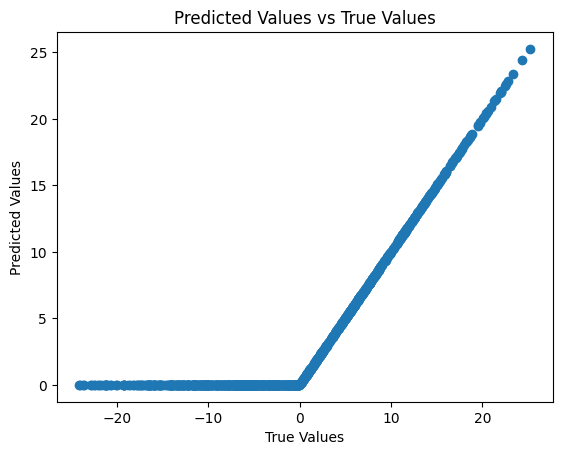

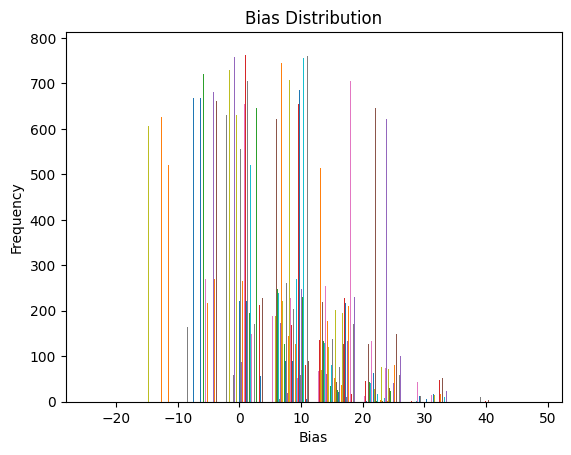

In [11]:

# Creating a tensorboard writer
writer = tbx.SummaryWriter()

# Logging the losses and accuracies for each epoch
for epoch in range(best_n_epochs):
    writer.add_scalars("Loss", {"Train": best_train_losses[epoch], "Test": best_test_losses[epoch]}, epoch + 1)
    writer.add_scalars("Accuracy", {"Train": best_train_accuracies[epoch], "Test": best_test_accuracies[epoch]}, epoch + 1)

# Closing the writer
writer.close()

# Plotting the predicted values and true values for a random sample of 1000 test points
indices = np.random.choice(len(x_test), size=1000)
x_sample = x_test[indices]
y_sample = y_test[indices]
y_pred = best_net(x_sample).detach().numpy()
plt.scatter(y_sample, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted Values vs True Values")
plt.savefig("pred_vs_true.png")
plt.figure()

# Plotting the bias (difference between predicted values and true values) for a random sample of 1000 test points
bias = y_pred - y_sample.numpy()
plt.hist(bias)
plt.xlabel("Bias")
plt.ylabel("Frequency")
plt.title("Bias Distribution")
plt.savefig("bias_dist.png")
